In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from SALib.sample import saltelli
from SALib.analyze import sobol

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern,WhiteKernel,ConstantKernel,RBF,\
DotProduct,ExpSineSquared,RationalQuadratic

import joblib
from joblib import Parallel, delayed
from multiprocessing import Pool
import pandas as pd
from scipy.stats import gaussian_kde, skew, pearsonr
from scipy.special import expit, logit
%matplotlib inline
import random
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import r2_score
import emcee

CPU times: user 1.56 s, sys: 746 ms, total: 2.31 s
Wall time: 24.9 s


In [2]:
%%time
X = pd.read_excel('/g/data/xv83/jp6794/WRF/Exps/Pearse/June_analysis/Samples25_512(0-1).xlsx',
                  sheet_name='QMC_Sobol_sequence',header=None)
X

CPU times: user 306 ms, sys: 126 ms, total: 432 ms
Wall time: 3.95 s


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.987100,0.802393,0.011476,0.175775,0.829965,0.020376,0.028623,0.305757,0.718250,0.069816,...,0.524966,0.055185,0.191634,0.772546,0.764576,0.658355,0.605970,0.164641,0.139134,0.167717
1,0.445356,0.164809,0.857240,0.982509,0.145957,0.933698,0.527587,0.770432,0.175730,0.638426,...,0.442398,0.897476,0.770890,0.071556,0.250862,0.313071,0.325945,0.575195,0.512738,0.675451
2,0.181195,0.714363,0.415701,0.286757,0.259636,0.607756,0.284953,0.533767,0.354946,0.805830,...,0.753722,0.566235,0.254281,0.479156,0.649889,0.910389,0.147246,0.334487,0.441337,0.305585
3,0.628213,0.319244,0.702873,0.617474,0.700477,0.443915,0.783914,0.015044,0.757784,0.488194,...,0.218121,0.480796,0.708243,0.676725,0.147898,0.068904,0.929202,0.924727,0.813109,0.782226
4,0.571063,0.532547,0.903838,0.665455,0.609877,0.166497,0.487671,0.705045,0.471560,0.581991,...,0.078774,0.324262,0.547181,0.279965,0.905769,0.597904,0.712165,0.472145,0.969738,0.917727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.574173,0.437435,0.739135,0.057710,0.935122,0.606552,0.854125,0.822138,0.292553,0.728543,...,0.776027,0.705843,0.991164,0.753329,0.760776,0.365206,0.027464,0.918563,0.063535,0.380279
508,0.625478,0.711284,0.912985,0.228758,0.750346,0.751907,0.433084,0.397761,0.951703,0.322370,...,0.895843,0.611902,0.769158,0.165223,0.003889,0.835172,0.362177,0.497110,0.219309,0.264010
509,0.182359,0.317623,0.188438,0.929531,0.192189,0.165230,0.931681,0.932353,0.408221,0.875828,...,0.072035,0.465885,0.190192,0.991577,0.513632,0.177267,0.581640,0.774790,0.597535,0.771775
510,0.448472,0.803218,0.504426,0.371469,0.336330,0.370602,0.130858,0.637471,0.119634,0.551078,...,0.639682,0.009551,0.706817,0.582526,0.394940,0.579270,0.883402,0.003045,0.418970,0.153374


In [3]:
%%time
RMSE = pd.read_excel('/g/data/xv83/jp6794/WRF/Exps/Pearse/June_analysis/liteoutput_RMSE.xlsx',
                  sheet_name='Sheet1')
RMSE

CPU times: user 97.3 ms, sys: 0 ns, total: 97.3 ms
Wall time: 126 ms


,surno3_rmse,nitrac_rmse,ox250m_rmse,oxminz_rmse,surfer_rmse,surchl_rmse,surpoc_rmse,intchl_rmse,intpoc_rmse,chmaxz_rmse,pmmaxz_rmse,intnpp_rmse,maxchl_rmse,fgco2_rmse,phylim_rmse,pocsink_rmse,sum_rmse,surno3_eq_rmse,fgco2_so_rmse
0,3.508156,126.757778,28.742789,433.091490,0.186239,0.262570,39.751799,21.530997,18678.853952,62.709314,57.979193,408.808010,1.259997,2.243734,0.594373,65.854061,19932.134452,3.141989,1.844191
1,5.408266,158.729040,32.534693,472.940815,0.163212,0.279483,44.759204,16.666774,19024.189979,58.531388,51.890739,446.547758,1.262457,2.281719,0.407544,70.481046,20387.074118,3.152540,2.263356
2,6.729797,172.561522,35.732240,482.969611,0.162271,0.294615,46.419322,21.266130,19975.887244,50.879765,56.177285,475.577326,1.263832,2.327551,0.554468,73.295467,21402.098446,5.514547,2.364076
3,6.104077,162.351759,34.282301,486.982733,0.161466,0.305834,43.936532,21.914650,19245.698349,61.503917,60.111996,429.297723,1.287795,2.330708,0.615265,72.445297,20629.330401,4.991677,2.267606
4,5.061853,148.509191,30.921682,461.399669,0.180788,0.292287,44.729061,18.388570,19230.691175,61.708540,51.739442,420.942599,1.289596,2.254897,0.612586,69.767680,20548.489615,3.182334,2.148126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,5.008928,147.020455,30.460554,443.158116,0.174818,0.258751,42.036359,35.318044,18907.855537,49.760696,48.636601,394.710736,1.195356,2.397533,0.420968,69.406390,20177.819840,3.901316,2.234554
508,3.907042,146.304029,33.162175,532.188703,0.161189,0.261837,43.936328,18.090798,18276.003167,66.566437,119.787407,462.963668,1.221011,2.207354,0.329235,67.917868,19775.008250,2.219004,2.096549
509,7.461768,177.294079,37.289646,488.614195,0.172172,0.295214,46.969052,18.091787,19980.267294,51.610229,52.739867,475.774976,1.294000,2.394596,0.658392,75.405147,21416.332414,7.151417,2.396312
510,6.009854,165.625279,33.861946,481.305824,0.165802,0.306382,43.204397,22.503683,19276.737446,48.145860,54.019223,415.551157,1.286316,2.281219,0.462063,71.931772,20623.398223,4.286599,2.281891


In [4]:
variables = ['fgco2_so_rmse', 'surchl_rmse', 'surno3_eq_rmse', 'chmaxz_rmse',
             'intnpp_rmse', 'surfer_rmse', 'phylim_rmse', 'pocsink_rmse']
Y = np.zeros((512, len(variables)))
for i, variable in enumerate(variables):
    Y[:,i] = RMSE[variable]
    # Normalising RMSE values (RMSE - min(RMSE)/max(RMSE) - min(RMSE))
    Y[:,i]=(Y[:,i]-Y[:,i].min())/(Y[:,i].max()-Y[:,i].min())

In [5]:
%%time
import warnings
warnings.filterwarnings('ignore')

n_vars = 8
N = 512

fold = np.int(8)
fold_size = np.int(N/fold)
GPR_score = np.zeros((fold,n_vars))
Y_PRED = np.zeros((N,n_vars))
Y_TRUE = np.zeros((N,n_vars))

for i in range(n_vars):
    '''
    kernel function for your Gaussian process regression
    kernel = constant kernel (adds a constant value to the diagonal of the covariance matrix) +
    Matern kernel (parameterized with a length scale of 25 dimensions (25 features) with each feature having a length scale of 1 and nu of 1.5) +
    white noise to the covariance matrix with a very small noise level
    '''
    #kernel = ConstantKernel()+1.0**2 * RBF(length_scale=np.ones((13,1)))+WhiteKernel(noise_level=1e-10)
    kernel = ConstantKernel()+Matern(length_scale=np.ones((25,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    '''
    Passing Matern kernel and setting 10 restarts of the optimizer for finding the kernel's parameters
    that maximize the log-marginal-likelihood
    '''
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    y_pred = np.zeros(1)
    y_true = np.zeros(1)
    for k in range(fold):
        X_train = pd.concat([X.iloc[0:k*fold_size,:],X.iloc[(k+1)*fold_size:,:]],axis=0)
        X_test = X.iloc[k*fold_size:(k+1)*fold_size,:]
        y_train = np.concatenate([Y[0:k*fold_size,i],Y[(k+1)*fold_size:,i]],axis=0)
        y_test = Y[k*fold_size:(k+1)*fold_size,i]
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        GPR_score[k,i] = r2_score(y_test,y_hat)
        y_pred = np.append(y_pred,y_hat,axis=0)
        y_true = np.append(y_true,y_test,axis=0)
    Y_PRED[:,i] = y_pred[1:]
    Y_TRUE[:,i] = y_true[1:]
    y_pred = pd.DataFrame(y_pred[1:])
    y_true = pd.DataFrame(y_true[1:])
    print(variables[i],r2_score(y_true,y_pred))

fgco2_so_rmse 0.9859637221732327
surchl_rmse 0.9271510278743407
surno3_eq_rmse 0.9712863911814106
chmaxz_rmse 0.8635007537663201
intnpp_rmse 0.9497709655437134
surfer_rmse 0.9151179358332959
phylim_rmse 0.8405430101342266
pocsink_rmse 0.9768635847408579
CPU times: user 21min 43s, sys: 13min 25s, total: 35min 8s
Wall time: 35min 8s


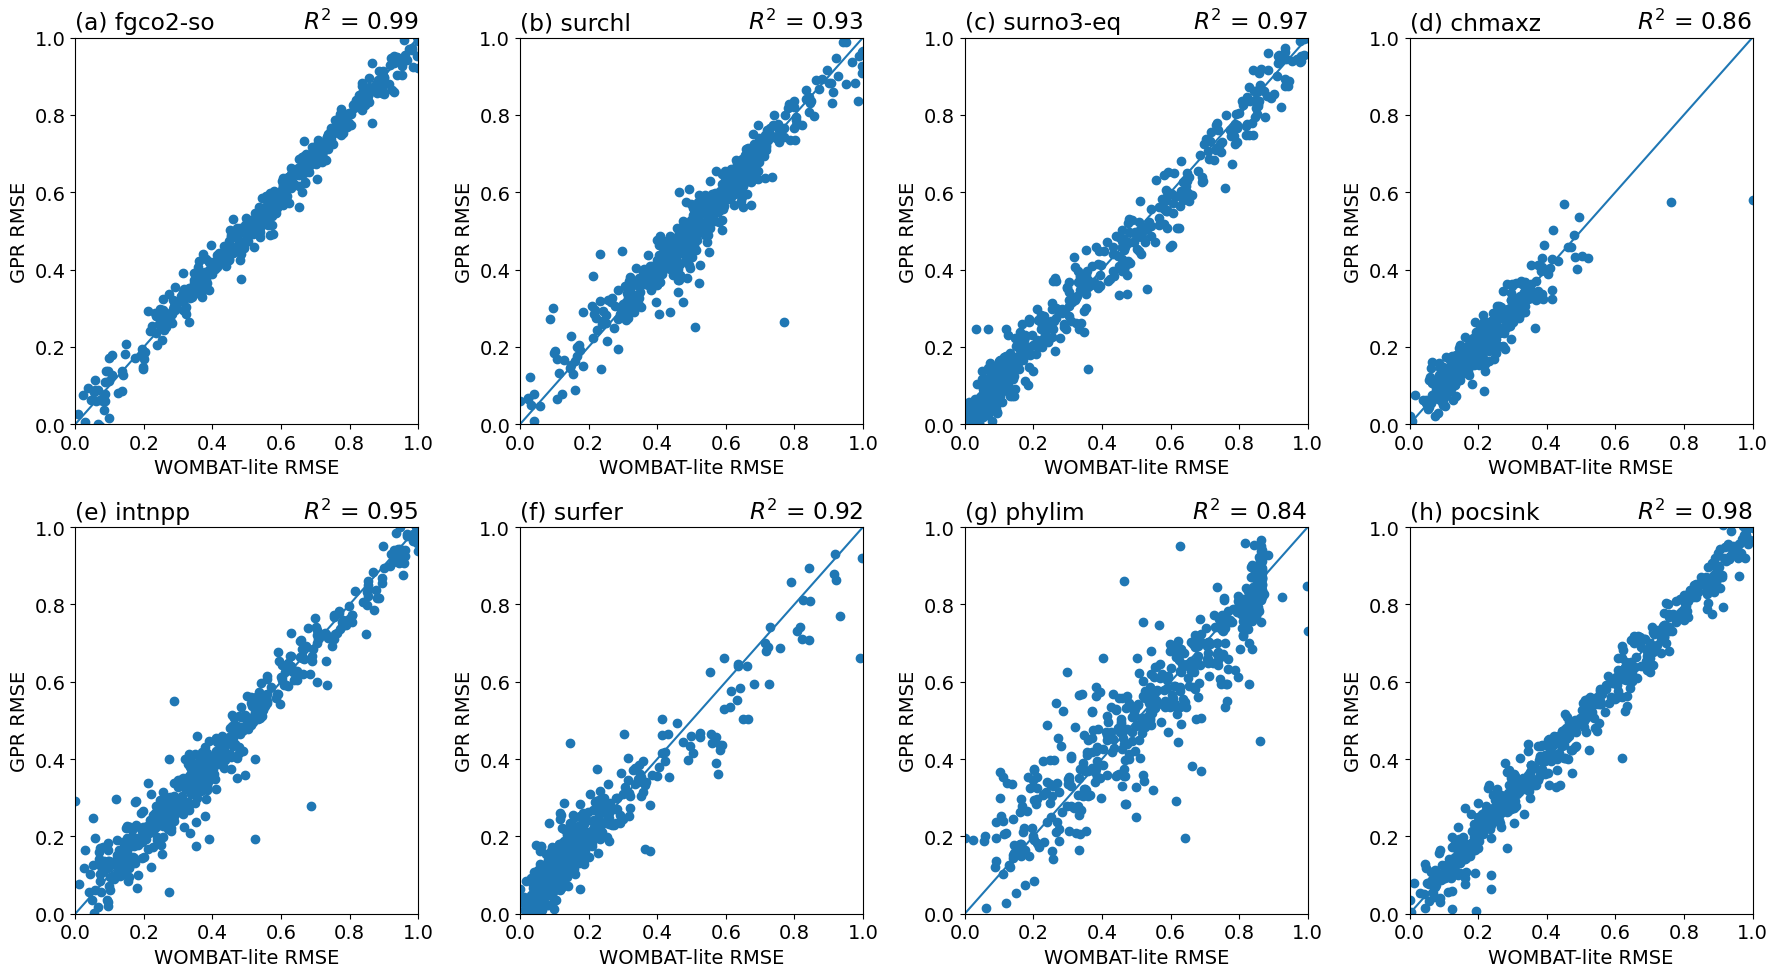

In [6]:
#fig = plt.figure(figsize=(14,10))
fig = plt.figure(figsize=(18,10))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14)
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']
var_names = ['fgco2-so', 'surchl', 'surno3-eq', 'chmaxz',
             'intnpp', 'surfer', 'phylim', 'pocsink']
for i in range(8):
    #ax = fig.add_subplot(2,3,i+1)
    ax = fig.add_subplot(2,4,i+1)
    ax.plot([0,1])
    ax.scatter(Y_TRUE[:,i],Y_PRED[:,i])
    ax.set_title(abc[i]+var_names[i],
               loc='left')
    ax.set_title('$R^2$ = '+str(round(r2_score(Y_TRUE[:,i],Y_PRED[:,i]),2)),
               loc='right')
    ax.set_xlabel('WOMBAT-lite RMSE')
    ax.set_ylabel('GPR RMSE')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
#plt.subplots_adjust(wspace=0.3,hspace=0.3)
plt.tight_layout()
plt.savefig('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/Fig_1_Sens_GPR_accuracy_512.png',
            dpi=600,bbox_inches='tight')

In [7]:
%%time
import warnings
warnings.filterwarnings('ignore')
GPR_score = np.zeros((8,3,8))
N = [128,256,512]
for i in range(8):
    #kernel = ConstantKernel()+ 1.0**2 * RBF(length_scale=np.ones((25,1))) + WhiteKernel(noise_level=1e-10)
    kernel = ConstantKernel()+Matern(length_scale=np.ones((25,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    for j in range(3):
        n = int(N[j]/8)
        y_pred = np.zeros(1)
        y_true = np.zeros(1)
        for k in range(8):
            X_train = pd.concat([X.iloc[0:k*n,:],X.iloc[(k+1)*n:N[j],:]],axis=0)
            X_test = X.iloc[k*n:(k+1)*n,:]
            y_train = np.concatenate([Y[0:k*n,i],Y[(k+1)*n:N[j],i]],axis=0)
            y_test = Y[k*n:(k+1)*n,i]
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            GPR_score[i,j,k] = r2_score(y_test,y_hat)
            y_pred = np.append(y_pred,y_hat,axis=0)
            y_true = np.append(y_true,y_test,axis=0)
        y_pred = pd.DataFrame(y_pred[1:])
        y_true = pd.DataFrame(y_true[1:])
        print(variables[i],'N=',N[j],r2_score(y_true,y_pred))

fgco2_so_rmse N= 128 0.9103847228108592
fgco2_so_rmse N= 256 0.9755465161298265
fgco2_so_rmse N= 512 0.9859637634077075
surchl_rmse N= 128 0.8293521913728983
surchl_rmse N= 256 0.9073384607371995
surchl_rmse N= 512 0.9271511973517144
surno3_eq_rmse N= 128 0.9037091660282165
surno3_eq_rmse N= 256 0.9395206281324007
surno3_eq_rmse N= 512 0.9712854243432548
chmaxz_rmse N= 128 0.5243525671570672
chmaxz_rmse N= 256 0.6291966881768933
chmaxz_rmse N= 512 0.8635086376307872
intnpp_rmse N= 128 0.8918048858241012
intnpp_rmse N= 256 0.9318665443670323
intnpp_rmse N= 512 0.949772374510277
surfer_rmse N= 128 0.7792379071374562
surfer_rmse N= 256 0.8352709689967422
surfer_rmse N= 512 0.9151108169794936
phylim_rmse N= 128 0.5909688822463891
phylim_rmse N= 256 0.701305156613826
phylim_rmse N= 512 0.8403654512505814
pocsink_rmse N= 128 0.926911952352817
pocsink_rmse N= 256 0.9436310375938542
pocsink_rmse N= 512 0.9768631890728429
CPU times: user 29min 55s, sys: 14min 51s, total: 44min 47s
Wall time: 44

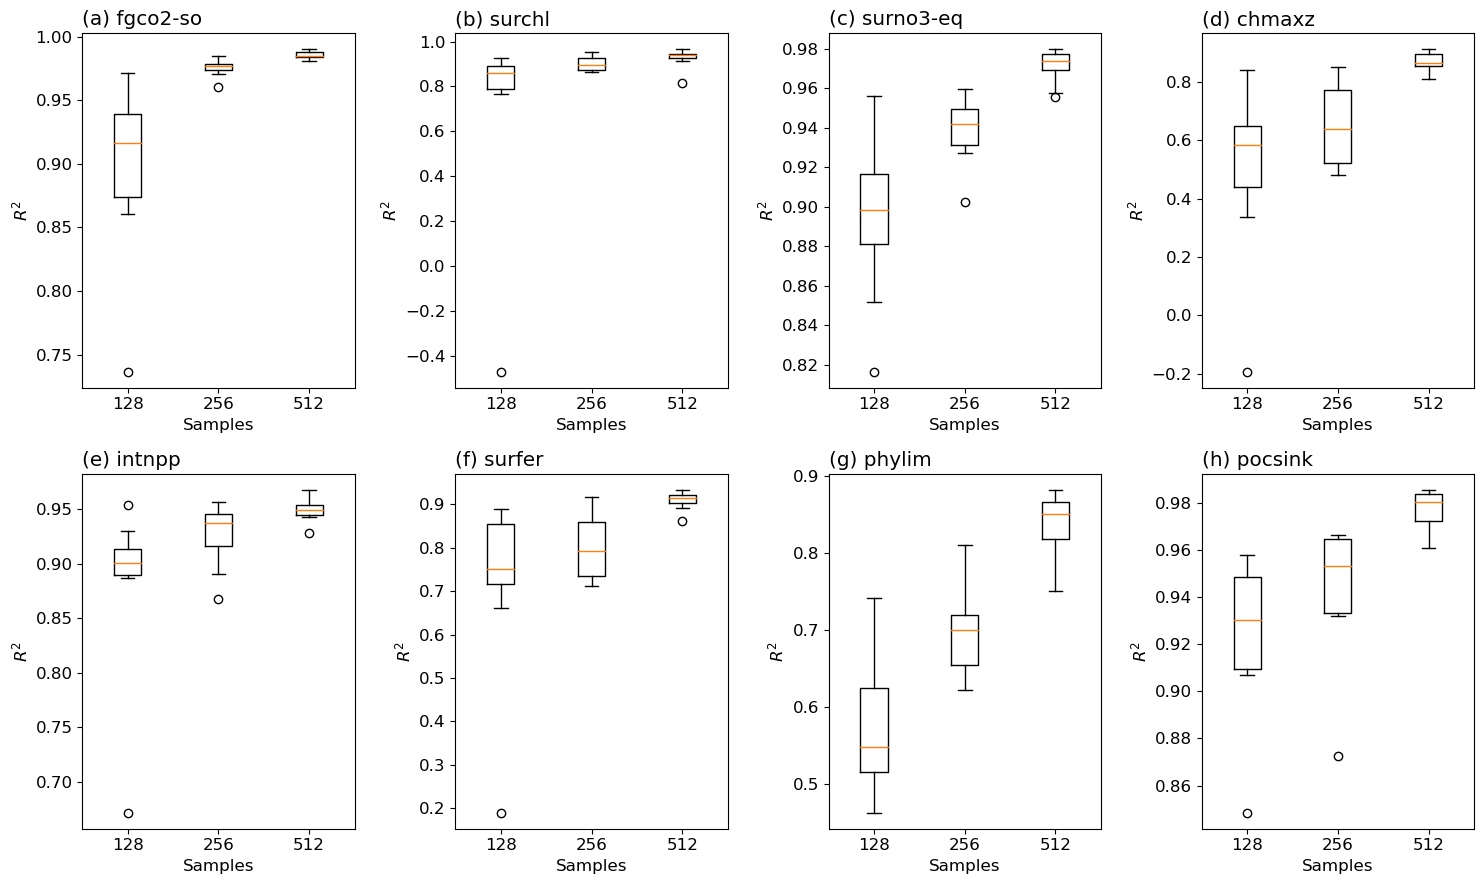

In [8]:
#fig = plt.figure(figsize=(12,9))
fig = plt.figure(figsize=(15,9))
plt.rc('font', size=12)    # fontsize of the all text
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('xtick', labelsize=12)
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']
for i in range(8):
    #axs = fig.add_subplot(2,3,i+1)
    axs = fig.add_subplot(2,4,i+1)
    axs.boxplot(GPR_score[i,0:3,:].T)
    axs.set_title(abc[i]+var_names[i],loc='left')
    axs.set_ylabel('$R^2$')
    axs.set_xlabel('Samples')
    axs.set_xticklabels(['128','256','512'])
plt.subplots_adjust(wspace=0.3,hspace=0.4)
plt.tight_layout()
plt.savefig('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/Fig_2_Sens_GPR_sample_sensitivity_512.png',
            dpi=600,bbox_inches='tight')

In [6]:
%%time
problem = {
    'num_vars': 25,
    'names': ['P1', 'P2', 'P3','P4', 'P5', 'P6','P7', 'P8', 'P9','P10', 'P11', 'P12',
             'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25'],
    'bounds': [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],
               [0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]       
}
param_values = saltelli.sample(problem, 1024, calc_second_order=True)
print(param_values.shape, max(param_values[:,0]))

(53248, 25) 0.99951171875
CPU times: user 499 ms, sys: 0 ns, total: 499 ms
Wall time: 498 ms


In [7]:
%%time
n_vars = 8
s1 = np.zeros((n_vars,25))
st = np.zeros((n_vars,25))
s2 = np.zeros((n_vars,25,25))
for i in range(n_vars):
    y = Y[:,i]
    #kernel = ConstantKernel()+1.0**2 * RBF(length_scale=np.ones((25,1)))+WhiteKernel(noise_level=1e-5)
    kernel = ConstantKernel()+Matern(length_scale=np.ones((25,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    model.fit(X, y)
    y_hat = model.predict(param_values)
    Si = sobol.analyze(problem, y_hat, parallel=True, n_processors= 2, print_to_console=False)
    print(Si['ST'])
    st[i,...] = Si['ST']
    s1[i,...] = Si['S1']
    s2[i,...] = Si['S2']

[6.13234139e-01 7.40291228e-03 7.01713234e-10 1.21558635e-03
 1.70091898e-05 8.85211220e-02 4.75484873e-02 7.44662884e-03
 2.02415285e-04 3.23474350e-03 6.43726244e-02 3.06443094e-04
 2.14501105e-04 1.00184242e-01 1.74497563e-02 8.70161562e-04
 4.75586724e-02 1.56881797e-04 1.53364719e-03 1.10408234e-02
 5.42262133e-02 1.58679186e-04 1.34888680e-02 4.92454657e-04
 1.66665645e-04]
[4.08260827e-01 5.76251846e-03 9.46667053e-14 1.19149566e-02
 2.17570152e-04 7.28334736e-02 7.10963202e-02 1.39508999e-02
 6.54436675e-03 1.10777402e-01 1.75791521e-01 4.94596474e-03
 1.46882593e-03 1.97095114e-01 3.91363124e-03 4.92676647e-03
 5.00601431e-02 1.11971189e-03 8.20869603e-03 1.25874207e-02
 1.71214376e-02 7.69365450e-13 1.31262869e-04 1.33848040e-15
 1.16562307e-15]
[5.67521578e-01 8.54948495e-03 2.25751208e-16 7.46724076e-03
 1.13926462e-16 1.07801354e-02 9.95988121e-03 3.71771728e-04
 7.89065545e-04 1.90338648e-03 1.75030712e-01 2.43805114e-03
 1.47803625e-10 1.92208588e-02 5.10091044e-03 4.036

In [8]:
var_names = [
    'air-sea flux of CO₂ (90°S-20°S)', 
    'Surface chlorophyll', 
    'Surface nitrate (20°S-20°N)', 
    'Depth of the chlorophyll max',
    'depth-integrated net primary production', 
    'Surface dissolved iron', 
    'primary limiting nutrient', 
    'sinking particle flux'
]
df = pd.DataFrame(data=st,
                    index=var_names,
                    columns=problem['names'])
df_t = df.T
df_t = (df_t-df_t.min())/(df_t.max()-df_t.min())
df = df_t.T
df

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25
air-sea flux of CO₂ (90°S-20°S),1.000000,0.012072,0.000000e+00,0.001982,2.773572e-05,1.443513e-01,0.077537,1.214321e-02,3.300772e-04,5.274890e-03,...,1.418970e-03,0.077554,2.558258e-04,0.002501,0.018004,0.088427,2.587568e-04,2.199628e-02,8.030439e-04,2.717803e-04
Surface chlorophyll,1.000000,0.014115,2.290229e-13,0.029185,5.329195e-04,1.783994e-01,0.174144,3.417154e-02,1.602987e-02,2.713398e-01,...,1.206769e-02,0.122618,2.742639e-03,0.020106,0.030832,0.041937,1.881640e-12,3.215172e-04,4.233992e-16,0.000000e+00
Surface nitrate (20°S-20°N),1.000000,0.015065,1.970405e-16,0.013158,0.000000e+00,1.899511e-02,0.017550,6.550795e-04,1.390371e-03,3.353857e-03,...,7.112612e-03,0.040358,4.291018e-04,0.093027,0.121455,0.269131,8.434567e-04,3.266100e-13,4.256469e-13,2.538778e-04
Depth of the chlorophyll max,1.000000,0.077411,1.350676e-02,0.097640,5.729127e-14,5.204303e-15,0.161916,0.000000e+00,2.299528e-02,1.125593e-01,...,1.641310e-02,0.001372,3.986267e-14,0.121601,0.093376,0.156648,7.532185e-04,2.718273e-14,1.419937e-04,4.415003e-11
depth-integrated net primary production,1.000000,0.013742,1.082956e-12,0.032688,1.156081e-04,1.213819e-02,0.012926,7.788744e-04,1.207239e-17,4.428400e-12,...,1.754499e-02,0.009231,1.208835e-03,0.022018,0.067420,0.096064,0.000000e+00,5.638645e-15,1.220665e-07,2.189002e-09
Surface dissolved iron,1.000000,0.005342,3.149079e-15,0.013474,5.151822e-16,1.527388e-01,0.185490,9.098451e-16,2.638474e-15,3.238633e-15,...,2.663304e-03,0.015715,7.560009e-14,0.046655,0.025787,0.038993,1.410370e-15,1.554564e-15,4.481755e-16,9.329128e-15
primary limiting nutrient,0.732448,0.017581,3.634660e-16,0.314118,1.773662e-16,1.000000e+00,0.438755,1.264596e-01,9.410522e-17,6.983299e-02,...,1.066415e-16,0.076309,9.808402e-16,0.010834,0.018148,0.089345,7.845463e-16,2.551986e-17,0.000000e+00,6.670628e-16
sinking particle flux,1.000000,0.029258,0.000000e+00,0.012676,6.448735e-05,9.571944e-03,0.023806,9.919360e-04,7.216365e-05,3.104225e-03,...,4.874381e-03,0.062102,8.714863e-04,0.020482,0.065561,0.176283,2.625375e-04,2.099248e-11,1.403321e-05,1.253521e-04


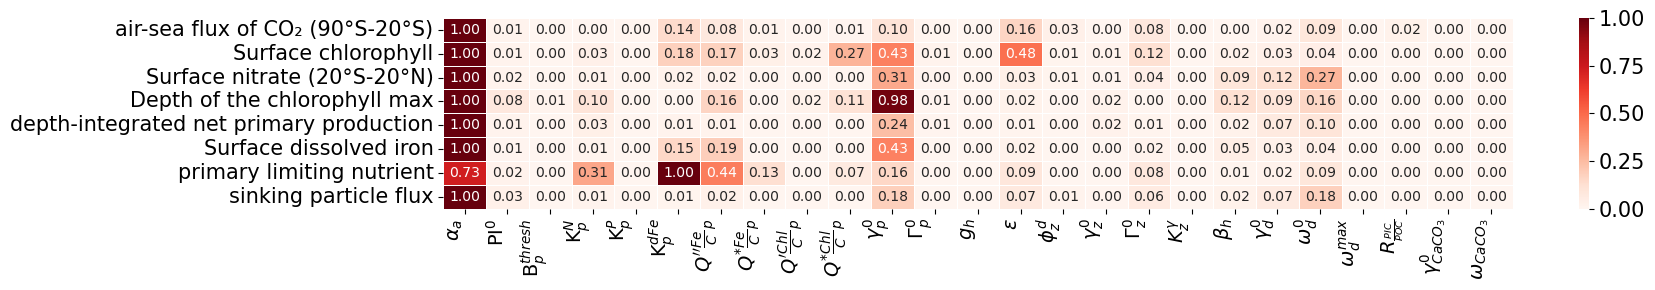

In [11]:
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
ax = plt.figure(figsize=(18,3))
ax = sns.heatmap(df,cmap="Reds",linewidths=.5, annot=True,fmt=".2f")
plt.xticks(rotation='horizontal')
ax.set_xticklabels([r'$\alpha_{a}$', r'PI$^0$', r'B$^{thresh}_{p}$' , r'K$^{N}_{p}$', r'K$^{P}_{p}$', r'K$^{dFe}_{p}$',r"$Q^{\prime\prime} \frac{Fe}{C}_{p}$", r'$Q^{*} \frac{Fe}{C}_{p}$', 
                        r'$Q^{\prime} \frac{Chl}{C}_{p}$',r'$Q^{*} \frac{Chl}{C}_{p}$', r'$\gamma^{0}_{p}$', r'$\Gamma^{0}_{p}$',
             r'$g_{h}$', r'$\epsilon$', r'$\phi^{d}_{z}$', r'$\gamma^{0}_{z}$', r'$\Gamma^{0}_{z}$', r'$K^{\gamma}_{z}$', r'$\beta_{h}$', r'$\gamma^{0}_{d}$', r'$\omega^{0}_{d}$', r'$\omega^{max}_{d}$', 
                        r'$R_{\frac{PIC}{POC}}$', r'$\gamma^{0}_{CaCO_3}$', r'$\omega_{CaCO_3}$'], rotation=90,   # Rotate for better readability
    fontsize=14,   # Increase font size for readability
    ha='right'     # Align text to the right for better vertical readability
                      )
plt.tight_layout()
#plt.savefig('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/Fig_S1_Sens_GPR_Sobol_ST_heatmap_new_cost.png',
#            dpi=600,bbox_inches='tight')

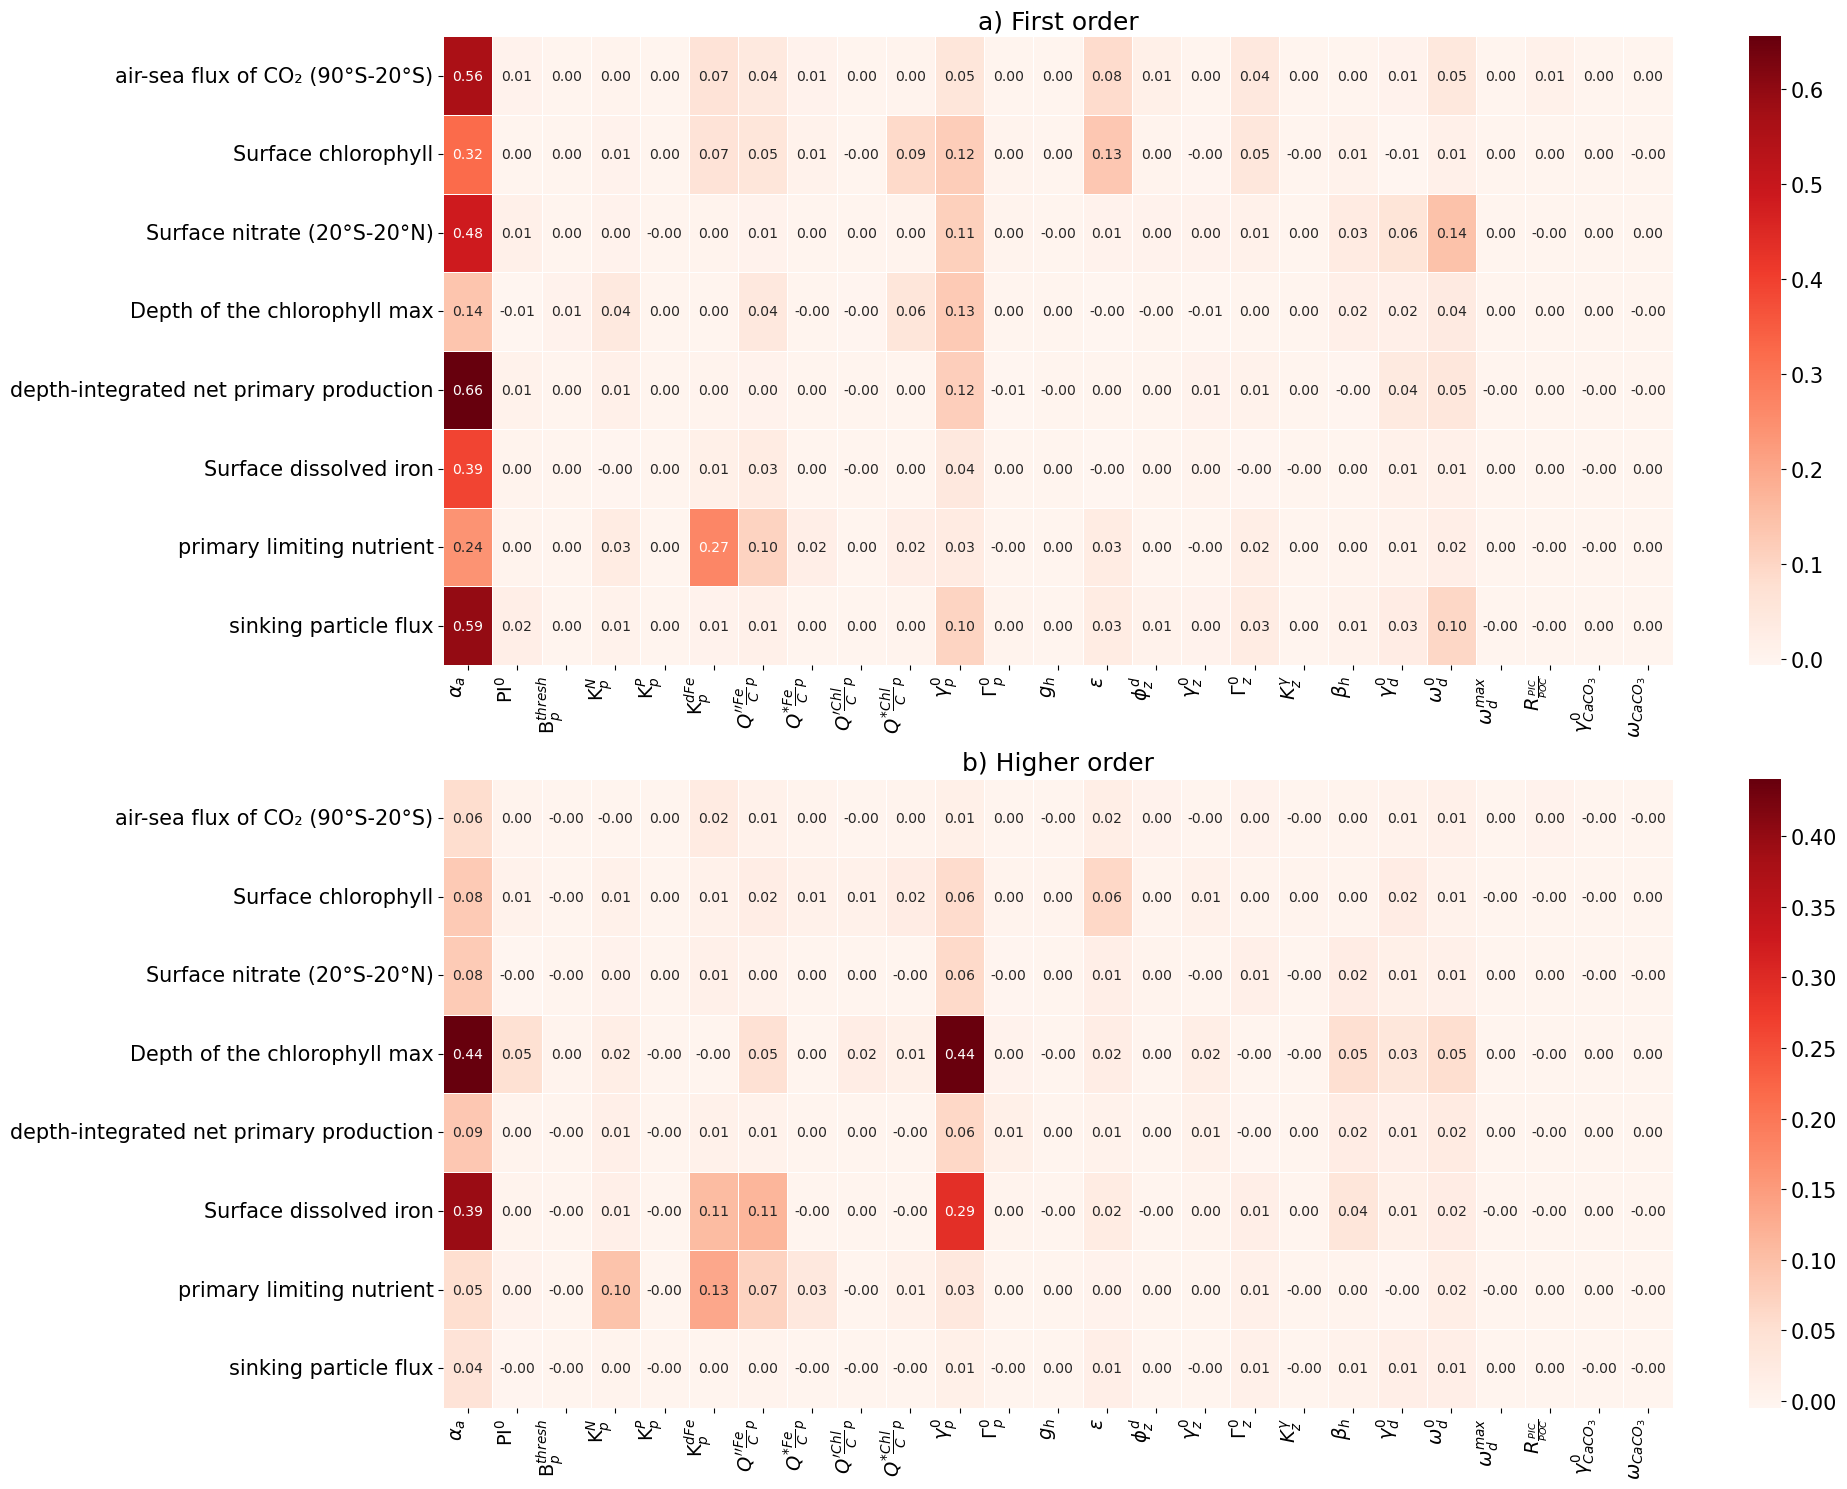

In [12]:
var_names = [
    'air-sea flux of CO₂ (90°S-20°S)', 
    'Surface chlorophyll', 
    'Surface nitrate (20°S-20°N)', 
    'Depth of the chlorophyll max',
    'depth-integrated net primary production', 
    'Surface dissolved iron', 
    'primary limiting nutrient', 
    'sinking particle flux'
]

# First dataset processing
df1 = pd.DataFrame(data=s1, index=var_names, columns=problem['names'])
df_t1 = df1.T
#df_t1 = (df_t1 - df_t1.min()) / (df_t1.max() - df_t1.min())
df1 = df_t1.T

# Second dataset processing
df2 = pd.DataFrame(data=(st - s1), index=var_names, columns=problem['names'])
df_t2 = df2.T
#df_t2 = (df_t2 - df_t2.min()) / (df_t2.max() - df_t2.min())
df2 = df_t2.T

# Common x-tick labels
xtick_labels = [
    r'$\alpha_{a}$', r'PI$^0$', r'B$^{thresh}_{p}$', r'K$^{N}_{p}$', r'K$^{P}_{p}$', r'K$^{dFe}_{p}$',
    r"$Q^{\prime\prime} \frac{Fe}{C}_{p}$", r'$Q^{*} \frac{Fe}{C}_{p}$',
    r'$Q^{\prime} \frac{Chl}{C}_{p}$', r'$Q^{*} \frac{Chl}{C}_{p}$', r'$\gamma^{0}_{p}$', r'$\Gamma^{0}_{p}$',
    r'$g_{h}$', r'$\epsilon$', r'$\phi^{d}_{z}$', r'$\gamma^{0}_{z}$', r'$\Gamma^{0}_{z}$',
    r'$K^{\gamma}_{z}$', r'$\beta_{h}$', r'$\gamma^{0}_{d}$', r'$\omega^{0}_{d}$', r'$\omega^{max}_{d}$',
    r'$R_{\frac{PIC}{POC}}$', r'$\gamma^{0}_{CaCO_3}$', r'$\omega_{CaCO_3}$'
]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

# Plot first heatmap (subplot a)
sns.heatmap(df1, cmap="Reds", linewidths=0.5, annot=True, fmt=".2f", ax=axes[0])
axes[0].set_xticklabels(xtick_labels, rotation=90, fontsize=14, ha='right')
axes[0].set_title('a) First order', fontsize=18)

# Plot second heatmap (subplot b)
sns.heatmap(df2, cmap="Reds", linewidths=0.5, annot=True, fmt=".2f", ax=axes[1])
axes[1].set_xticklabels(xtick_labels, rotation=90, fontsize=14, ha='right')
axes[1].set_title('b) Higher order', fontsize=18)

# Adjust layout
plt.tight_layout()
#plt.savefig('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/Nov_Fig_S1_Sens_GPR_Sobol_ST_heatmap_new_cost.png',
#            dpi=600,bbox_inches='tight')

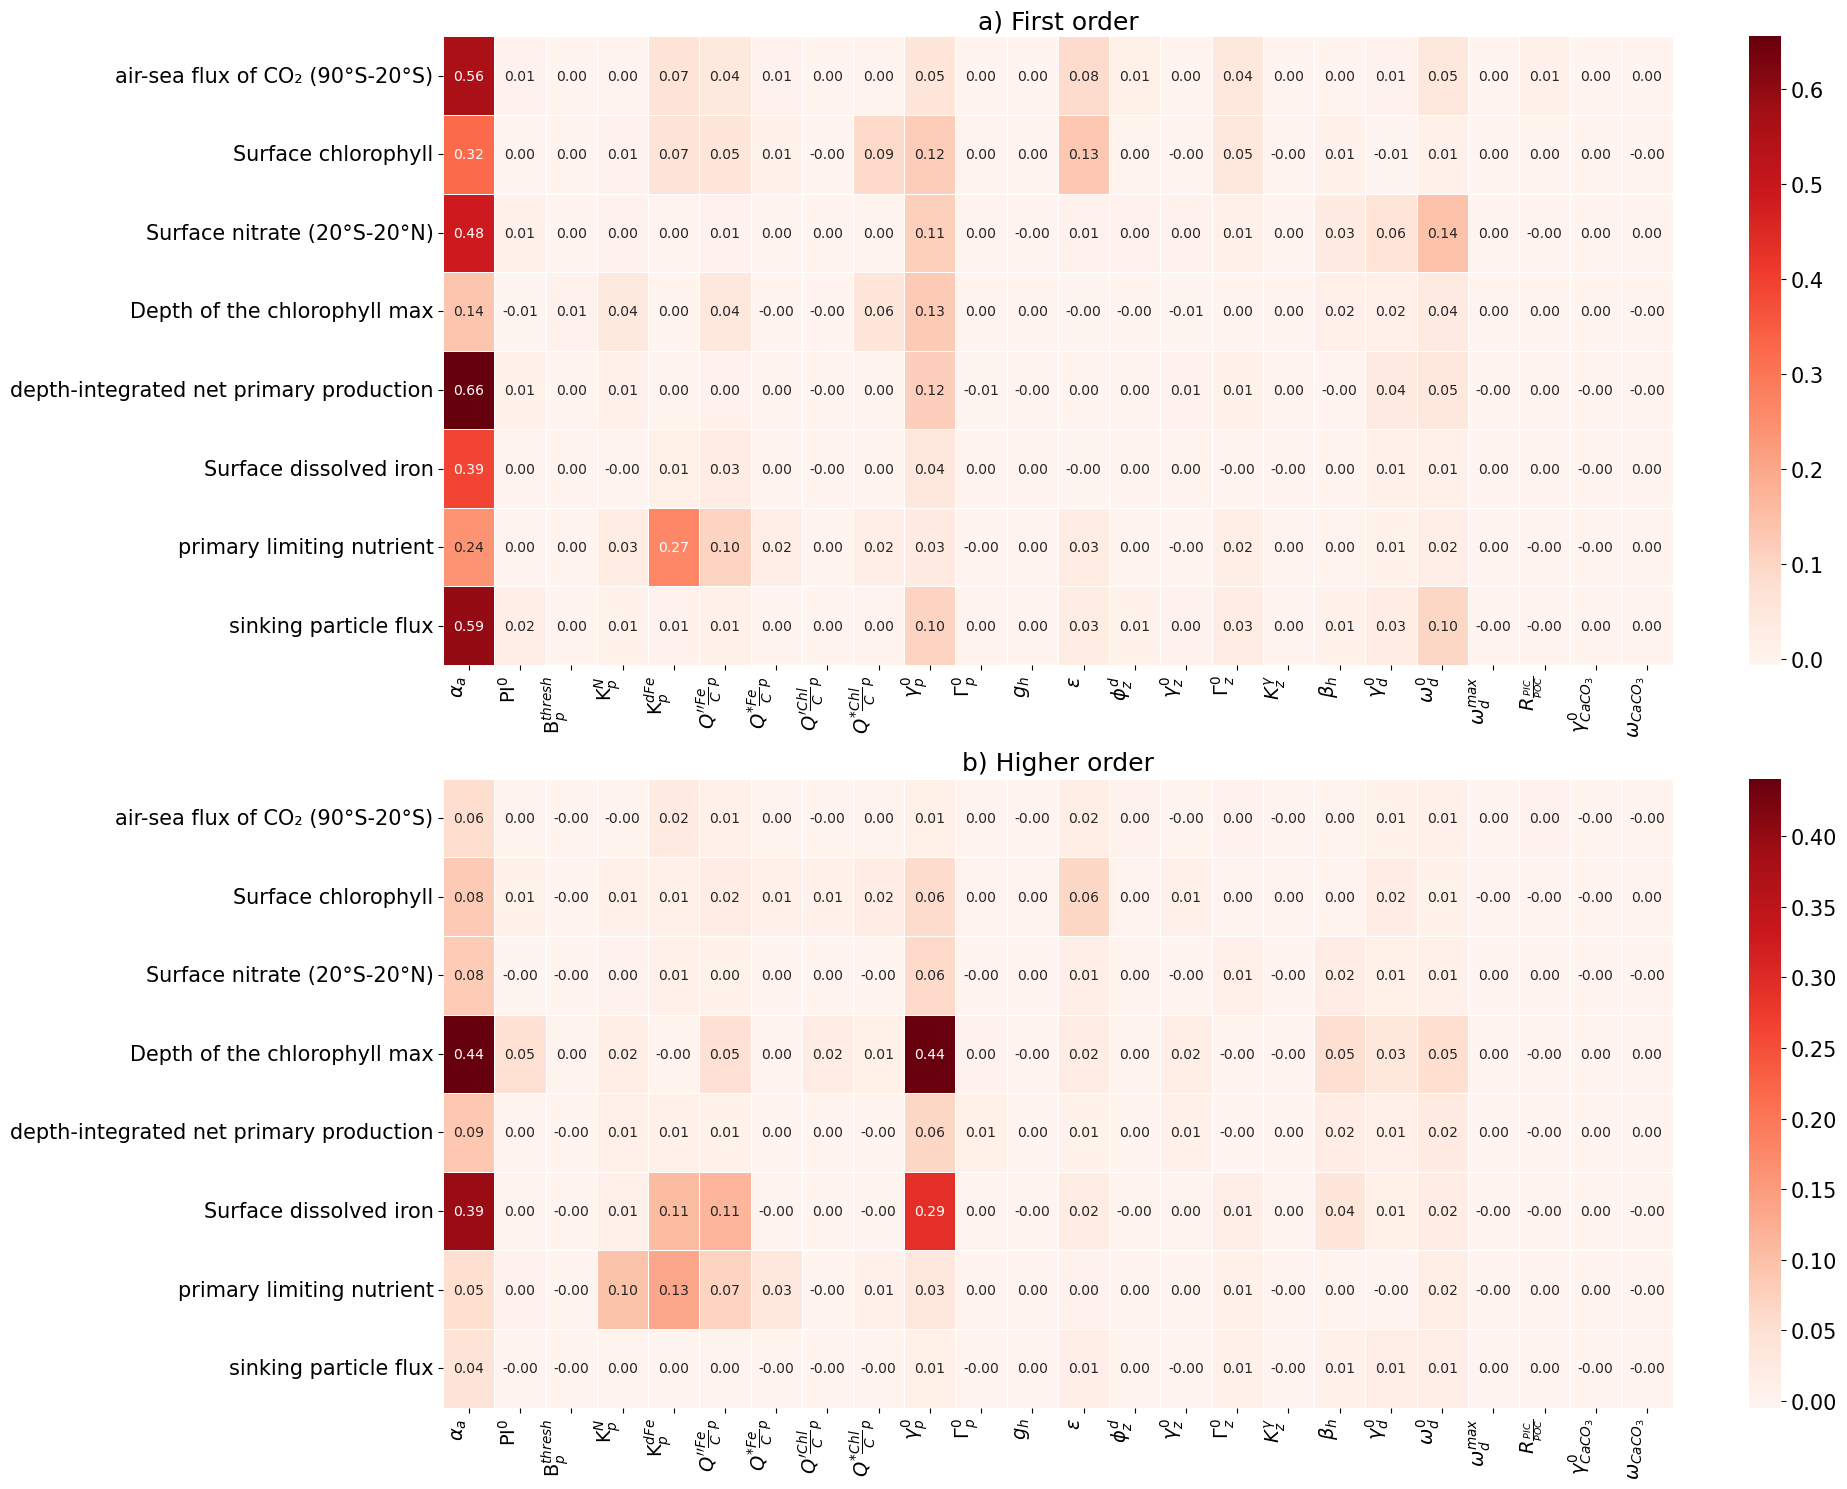

In [13]:
# Remove 'K^{P}_{p}' column from xtick_labels
xtick_labels = [
    r'$\alpha_{a}$', r'PI$^0$', r'B$^{thresh}_{p}$', r'K$^{N}_{p}$', r'K$^{dFe}_{p}$',
    r"$Q^{\prime\prime} \frac{Fe}{C}_{p}$", r'$Q^{*} \frac{Fe}{C}_{p}$',
    r'$Q^{\prime} \frac{Chl}{C}_{p}$', r'$Q^{*} \frac{Chl}{C}_{p}$', r'$\gamma^{0}_{p}$', r'$\Gamma^{0}_{p}$',
    r'$g_{h}$', r'$\epsilon$', r'$\phi^{d}_{z}$', r'$\gamma^{0}_{z}$', r'$\Gamma^{0}_{z}$',
    r'$K^{\gamma}_{z}$', r'$\beta_{h}$', r'$\gamma^{0}_{d}$', r'$\omega^{0}_{d}$', r'$\omega^{max}_{d}$',
    r'$R_{\frac{PIC}{POC}}$', r'$\gamma^{0}_{CaCO_3}$', r'$\omega_{CaCO_3}$'
]

# First dataset processing
df1 = pd.DataFrame(data=s1, index=var_names, columns=problem['names'])
df_t1 = df1.T
df1 = df_t1.T

# Second dataset processing
df2 = pd.DataFrame(data=(st - s1), index=var_names, columns=problem['names'])
df_t2 = df2.T
df2 = df_t2.T

# Remove 'K^{P}_{p}' column from dataframes
df1 = df1.drop(columns=['P5'], errors='ignore')
df2 = df2.drop(columns=['P5'], errors='ignore')

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

# Plot first heatmap (subplot a)
sns.heatmap(df1, cmap="Reds", linewidths=0.5, annot=True, fmt=".2f", ax=axes[0])
axes[0].set_xticklabels(xtick_labels, rotation=90, fontsize=14, ha='right')
axes[0].set_title('a) First order', fontsize=18)

# Plot second heatmap (subplot b)
sns.heatmap(df2, cmap="Reds", linewidths=0.5, annot=True, fmt=".2f", ax=axes[1])
axes[1].set_xticklabels(xtick_labels, rotation=90, fontsize=14, ha='right')
axes[1].set_title('b) Higher order', fontsize=18)

# Adjust layout
plt.tight_layout()
plt.savefig('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/Nov_Fig_S1_Sens_GPR_Sobol_ST_heatmap_new_cost_updated.png',
            dpi=600,bbox_inches='tight')

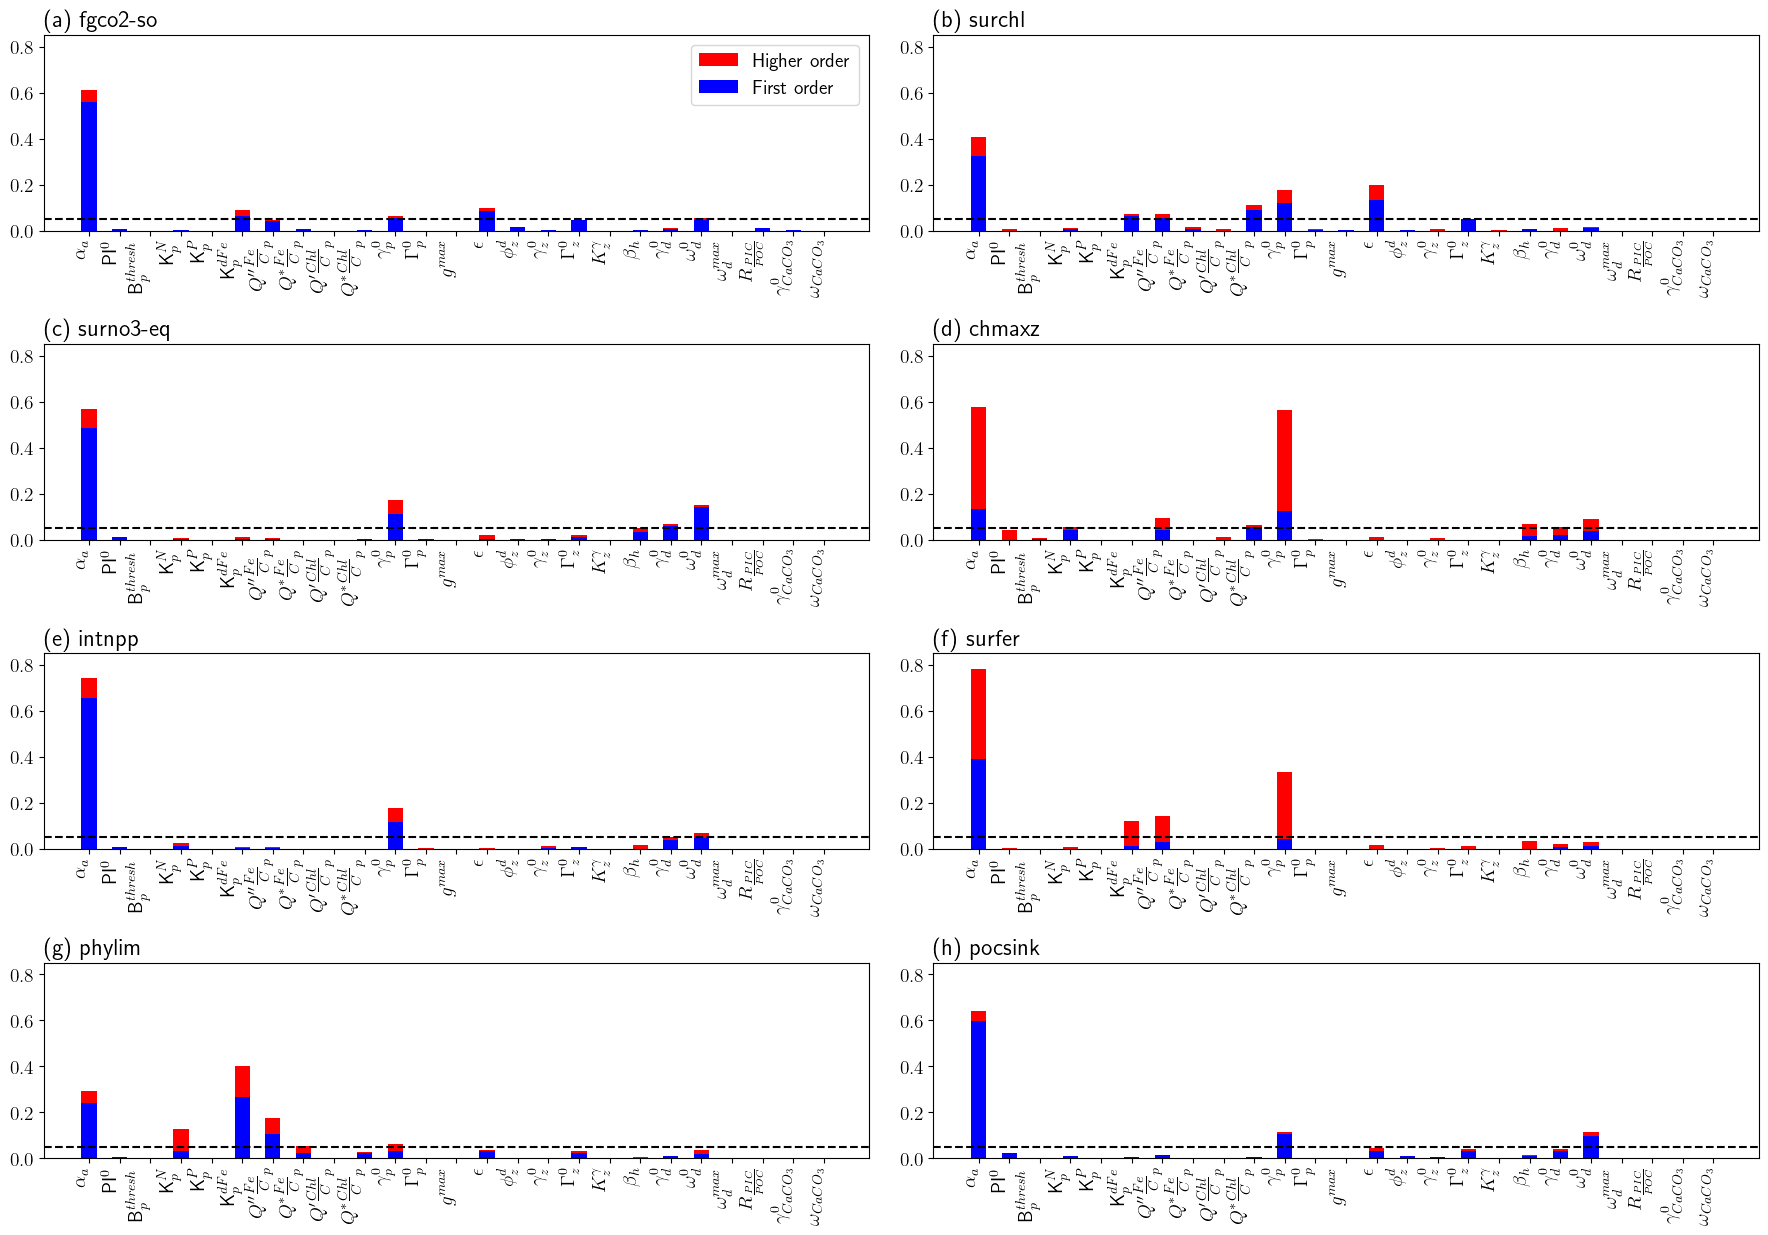

In [53]:
fig = plt.figure(figsize=(18,15))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14) 
plt.rcParams['text.usetex'] = True
x = np.arange(25)
width = 0.5
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']
for i in range(8):
    #ax = fig.add_subplot(4,2,i+1)
    ax = fig.add_subplot(5,2,i+1)
    ax.bar(x,st[:,:][i,:],width,color='red')
    ax.bar(x,s1[:,:][i,:],width,color='blue')
    ax.set_xticks(x)
    ax.set_xticklabels([r'$\alpha_{a}$', r'PI$^0$', r'B$^{thresh}_{p}$' , r'K$^{N}_{p}$', r'K$^{P}_{p}$', r'K$^{dFe}_{p}$',r"$Q^{\prime\prime} \frac{Fe}{C}_{p}$", r'$Q^{*} \frac{Fe}{C}_{p}$', 
                        r'$Q^{\prime} \frac{Chl}{C}_{p}$',r'$Q^{*} \frac{Chl}{C}_{p}$', r'$\gamma^{0}_{p}$', r'$\Gamma^{0}_{p}$',
             r'$g^{max}$', r'$\epsilon$', r'$\phi^{d}_{z}$', r'$\gamma^{0}_{z}$', r'$\Gamma^{0}_{z}$', r'$K^{\gamma}_{z}$', r'$\beta_{h}$', r'$\gamma^{0}_{d}$', r'$\omega^{0}_{d}$', r'$\omega^{max}_{d}$', 
                        r'$R_{\frac{PIC}{POC}}$', r'$\gamma^{0}_{CaCO_3}$', r'$\omega_{CaCO_3}$'], rotation=90,   # Rotate for better readability
    fontsize=14,   # Increase font size for readability
    ha='right'     # Align text to the right for better vertical readability
                      )
    
    ax.set_title(abc[i]+df.index[i],loc='left')
    ax.set_ylim(0, 0.85)
    if i == 0:
        ax.legend(['Higher order','First order'],loc='upper right')
    ax.axhline(y=0.05, color='black', linestyle='--')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.tight_layout()
plt.savefig('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/Fig_3_Sens_GPR_Sobol_ST_S1_barplot_new_cost.png',
            dpi=600,bbox_inches='tight')

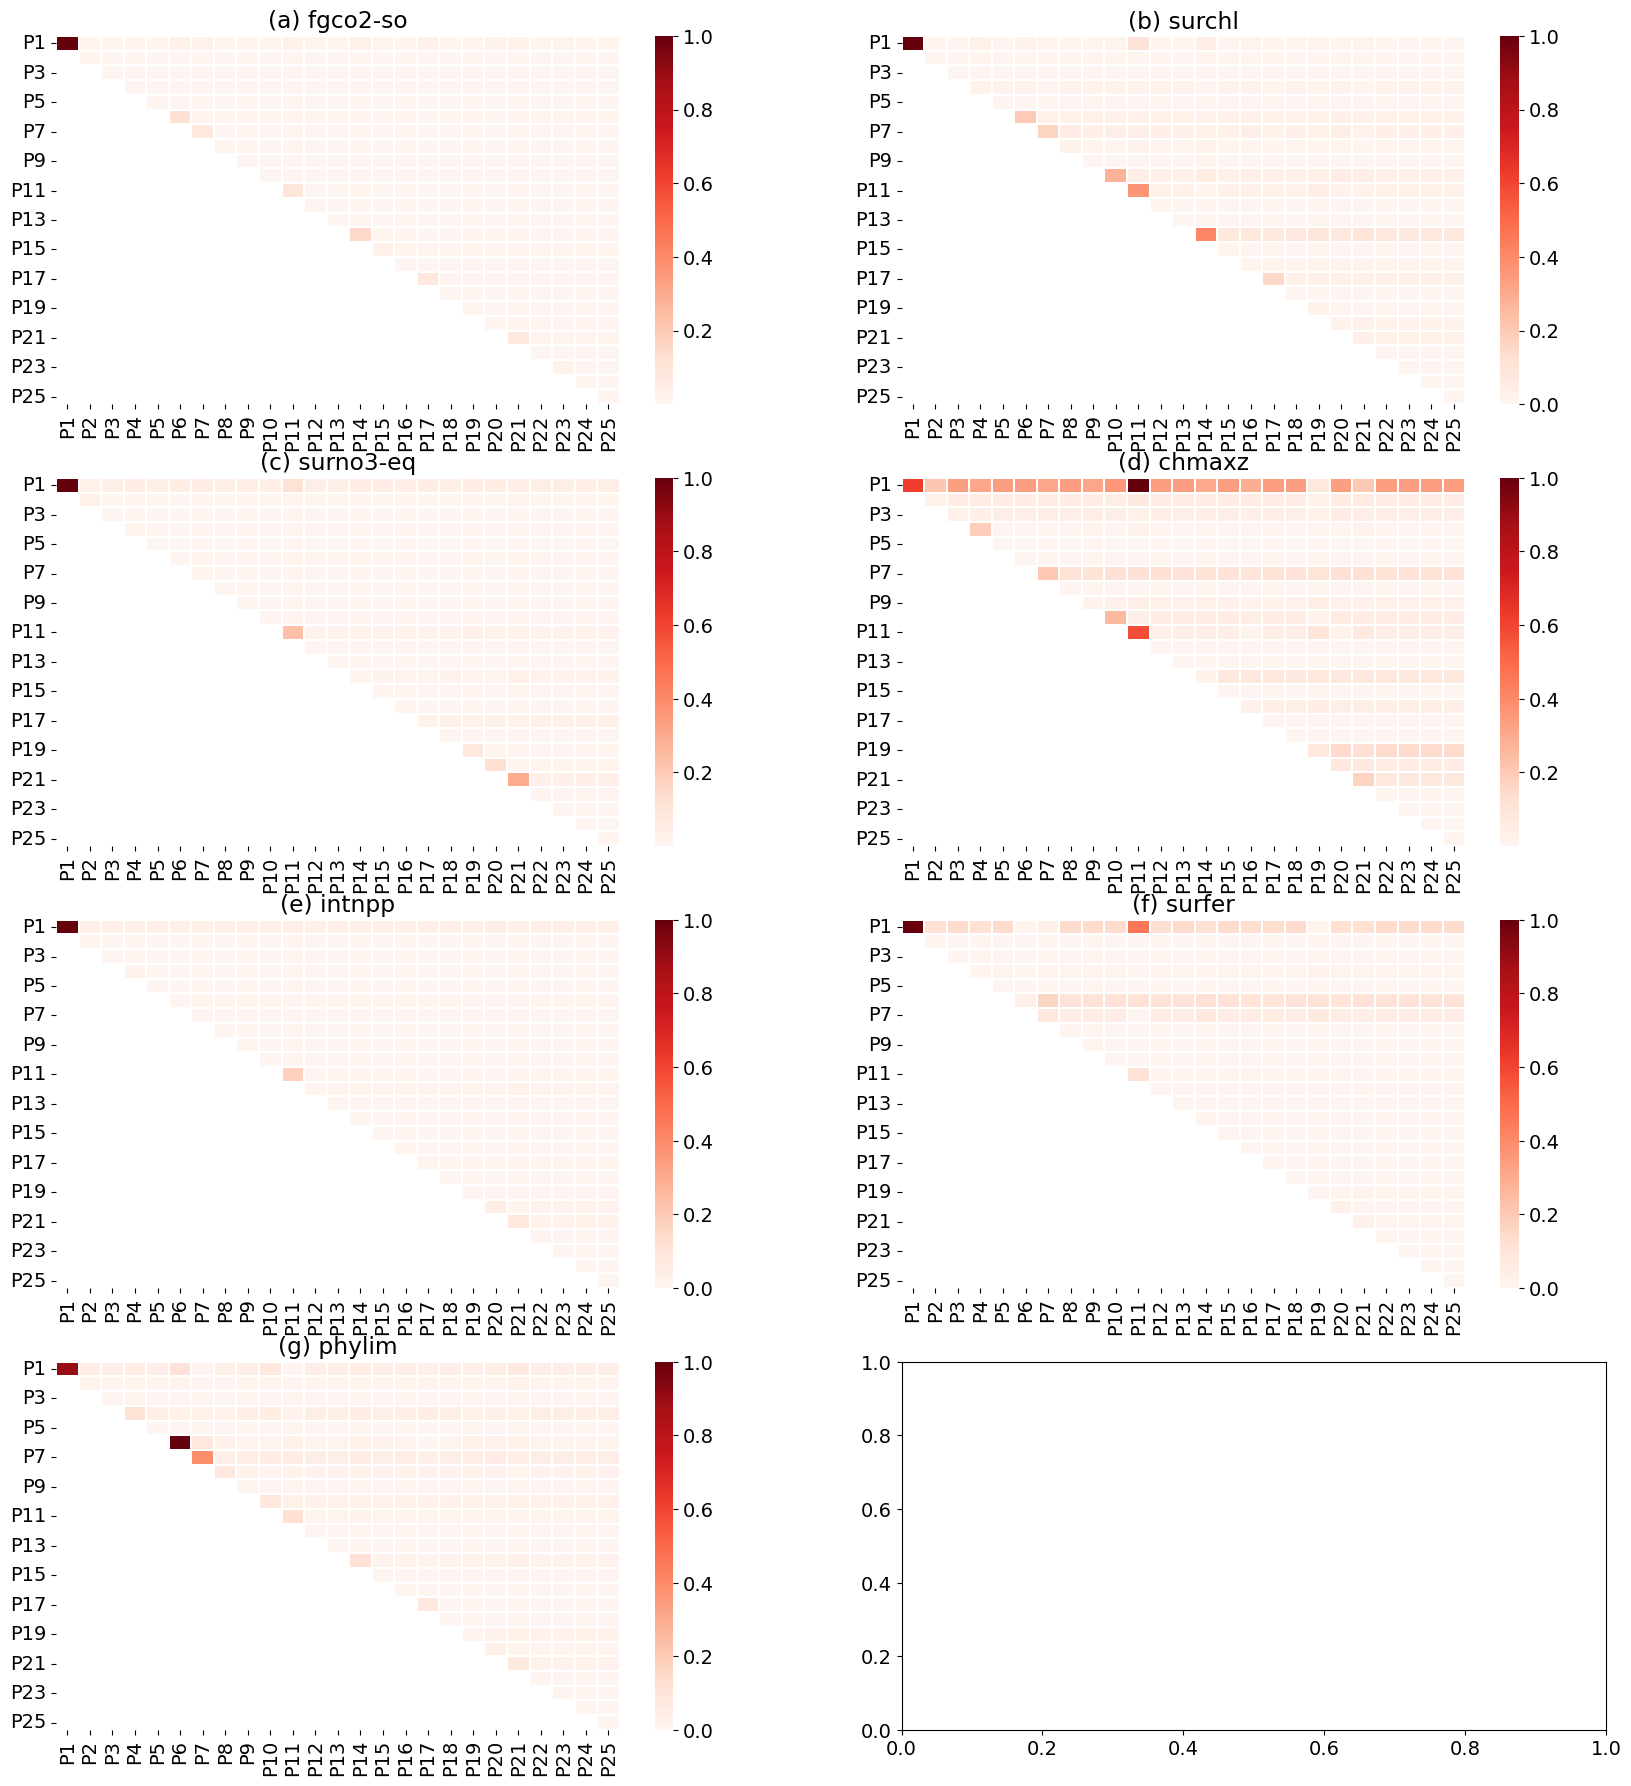

In [19]:
fig, ax = plt.subplots(4, 2, figsize=(20,22))
ax = ax.flatten()
for i in range(7):
    np.fill_diagonal(s2[i,...], s1[i,...])
    qf = pd.DataFrame(data=abs(s2[i,...]/np.nanmax(s2[i,...])),
                    index=problem['names'],
                    columns=problem['names'])
    sns.heatmap(qf,cmap="Reds", ax=ax[i], linewidths=.3)
    ax[i].set_title(abc[i]+df.index[i],loc='center')
#plt.savefig('/g/data/xv83/jp6794/WRF/Exps/Pearse/June_analysis/GPR_Sobol_S2_heatmap.png',
#            dpi=600,bbox_inches='tight')

Optimization of the sensitive parameters 

In [2]:
X_O = pd.read_excel('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/Samples13_512(0-1).xlsx',
                  sheet_name='QMC_Sobol_sequence',header=None)
X_O

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.987100,0.802393,0.011476,0.175775,0.829965,0.020376,0.028623,0.305757,0.718250,0.069816,0.549095,0.872515,0.703173
1,0.075842,0.077758,0.802941,0.850020,0.299921,0.949615,0.500547,0.720195,0.264388,0.511052,0.396175,0.468265,0.285229
2,0.472529,0.714937,0.441263,0.465054,0.143889,0.628338,0.483996,0.871863,0.168054,0.761147,0.028074,0.059879,0.951692
3,0.590565,0.412237,0.748215,0.509411,0.736008,0.339662,0.986682,0.160809,0.872866,0.319606,0.932952,0.655903,0.057220
4,0.745001,0.533078,0.936467,0.738067,0.619080,0.172663,0.271125,0.934597,0.069026,0.653796,0.200623,0.502146,0.821864
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.742923,0.337704,0.702187,0.039264,0.930558,0.626903,0.911565,0.660365,0.239367,0.568597,0.273523,0.300050,0.854233
508,0.592394,0.716986,0.890469,0.205390,0.797607,0.854417,0.314989,0.435163,0.951549,0.402360,0.607612,0.420739,0.025135
509,0.470702,0.410189,0.173955,0.757584,0.330336,0.174159,0.843065,0.599585,0.030900,0.953280,0.447117,0.761849,0.982065
510,0.077670,0.804259,0.570118,0.435153,0.236367,0.497419,0.172240,0.992473,0.434607,0.703201,0.063265,0.733347,0.257057


In [3]:
%%time
Error = pd.read_excel('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/cost_function_lite2_aug.xlsx',
                  sheet_name='cost_function')
Error

CPU times: user 94 ms, sys: 4.04 ms, total: 98 ms
Wall time: 168 ms


,fgco2_so,surchl,chmaxz,intnpp,surfer,phylim,surno3-eq-log,pocsink,global_sum,global_sum(fgco2),global_sum(surno3),global_sum(intnpp),global_sum(phylim)
0,0.296585,0.035927,0.037695,0.000000,0.322108,0.231097,0.774584,0.344308,2.042304,3.228645,5.140639,2.042304,2.966692
1,0.864355,0.565946,0.203522,0.300272,0.397072,0.304825,0.382708,0.457182,3.475883,6.933302,5.006716,4.676970,4.695184
2,0.863467,0.552490,0.055539,0.074650,0.318081,0.349882,0.192184,0.631935,3.038228,6.492095,3.806962,3.336827,4.437757
3,0.396156,0.182275,0.342084,0.238542,0.079568,0.257366,0.313645,0.339006,2.148642,3.733266,3.403223,3.102811,3.178108
4,0.682092,0.319869,0.213013,0.059483,0.167746,0.475989,0.062413,0.437850,2.418453,5.146820,2.668104,2.656385,4.322408
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.301732,0.105577,0.259357,0.077337,0.463175,0.803601,0.079102,0.214889,2.304770,3.511698,2.621176,2.614118,5.519174
508,0.270692,0.079838,0.180765,0.117625,0.252364,0.550375,0.178855,0.237484,1.867998,2.950765,2.583419,2.338497,4.069498
509,0.638477,0.462445,0.229583,0.083080,0.091752,0.538349,0.206198,0.359417,2.609301,5.163208,3.434093,2.941619,4.762696
510,0.880298,0.742662,0.143872,0.302340,0.455843,0.421882,0.386981,0.540948,3.874826,7.396019,5.422749,5.084186,5.562354


In [4]:
variables = ['fgco2_so', 'surchl', 'surno3-eq-log', 'chmaxz', 
             'intnpp', 'surfer', 'phylim', 'pocsink']
Y_O = np.zeros((512, len(variables)))
for i, variable in enumerate(variables):
    Y_O[:,i] = Error[variable]
    # Normalising Error values (Error - min(Error)/max(Error) - min(Error))
    Y_O[:,i]=(Y_O[:,i]-Y_O[:,i].min())/(Y_O[:,i].max()-Y_O[:,i].min())

In [58]:
%%time
import warnings
warnings.filterwarnings('ignore')

n_vars = 8
N = 512

fold = np.int(8)
fold_size = np.int(N/fold)
GPR_score = np.zeros((fold,n_vars))
Y_PRED = np.zeros((N,n_vars))
Y_TRUE = np.zeros((N,n_vars))

for i in range(n_vars):
    '''
    kernel function for your Gaussian process regression
    kernel = constant kernel (adds a constant value to the diagonal of the covariance matrix) +
    Matern kernel (parameterized with a length scale of 13 dimensions (13 features) with each feature having a length scale of 1 and nu of 1.5) +
    white noise to the covariance matrix with a very small noise level
    '''
    kernel = ConstantKernel()+Matern(length_scale=np.ones((13,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    '''
    Passing Matern kernel and setting 10 restarts of the optimizer for finding the kernel's parameters
    that maximize the log-marginal-likelihood
    '''
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    y_pred = np.zeros(1)
    y_true = np.zeros(1)
    for k in range(fold):
        X_train = pd.concat([X_O.iloc[0:k*fold_size,:],X_O.iloc[(k+1)*fold_size:,:]],axis=0)
        X_test = X_O.iloc[k*fold_size:(k+1)*fold_size,:]
        y_train = np.concatenate([Y_O[0:k*fold_size,i],Y_O[(k+1)*fold_size:,i]],axis=0)
        y_test = Y_O[k*fold_size:(k+1)*fold_size,i]
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        GPR_score[k,i] = r2_score(y_test,y_hat)
        y_pred = np.append(y_pred,y_hat,axis=0)
        y_true = np.append(y_true,y_test,axis=0)
    Y_PRED[:,i] = y_pred[1:]
    Y_TRUE[:,i] = y_true[1:]
    y_pred = pd.DataFrame(y_pred[1:])
    y_true = pd.DataFrame(y_true[1:])
    print(variables[i],r2_score(y_true,y_pred))

fgco2_so 0.9487446204710285
surchl 0.8387190769436498
surno3-eq-log 0.8212056503635624
chmaxz 0.9541216934330031
intnpp 0.8094250899457665
surfer 0.8059135489328679
phylim 0.7227435063935188
pocsink 0.8618507551598465
CPU times: user 12min 3s, sys: 3min 48s, total: 15min 51s
Wall time: 15min 52s


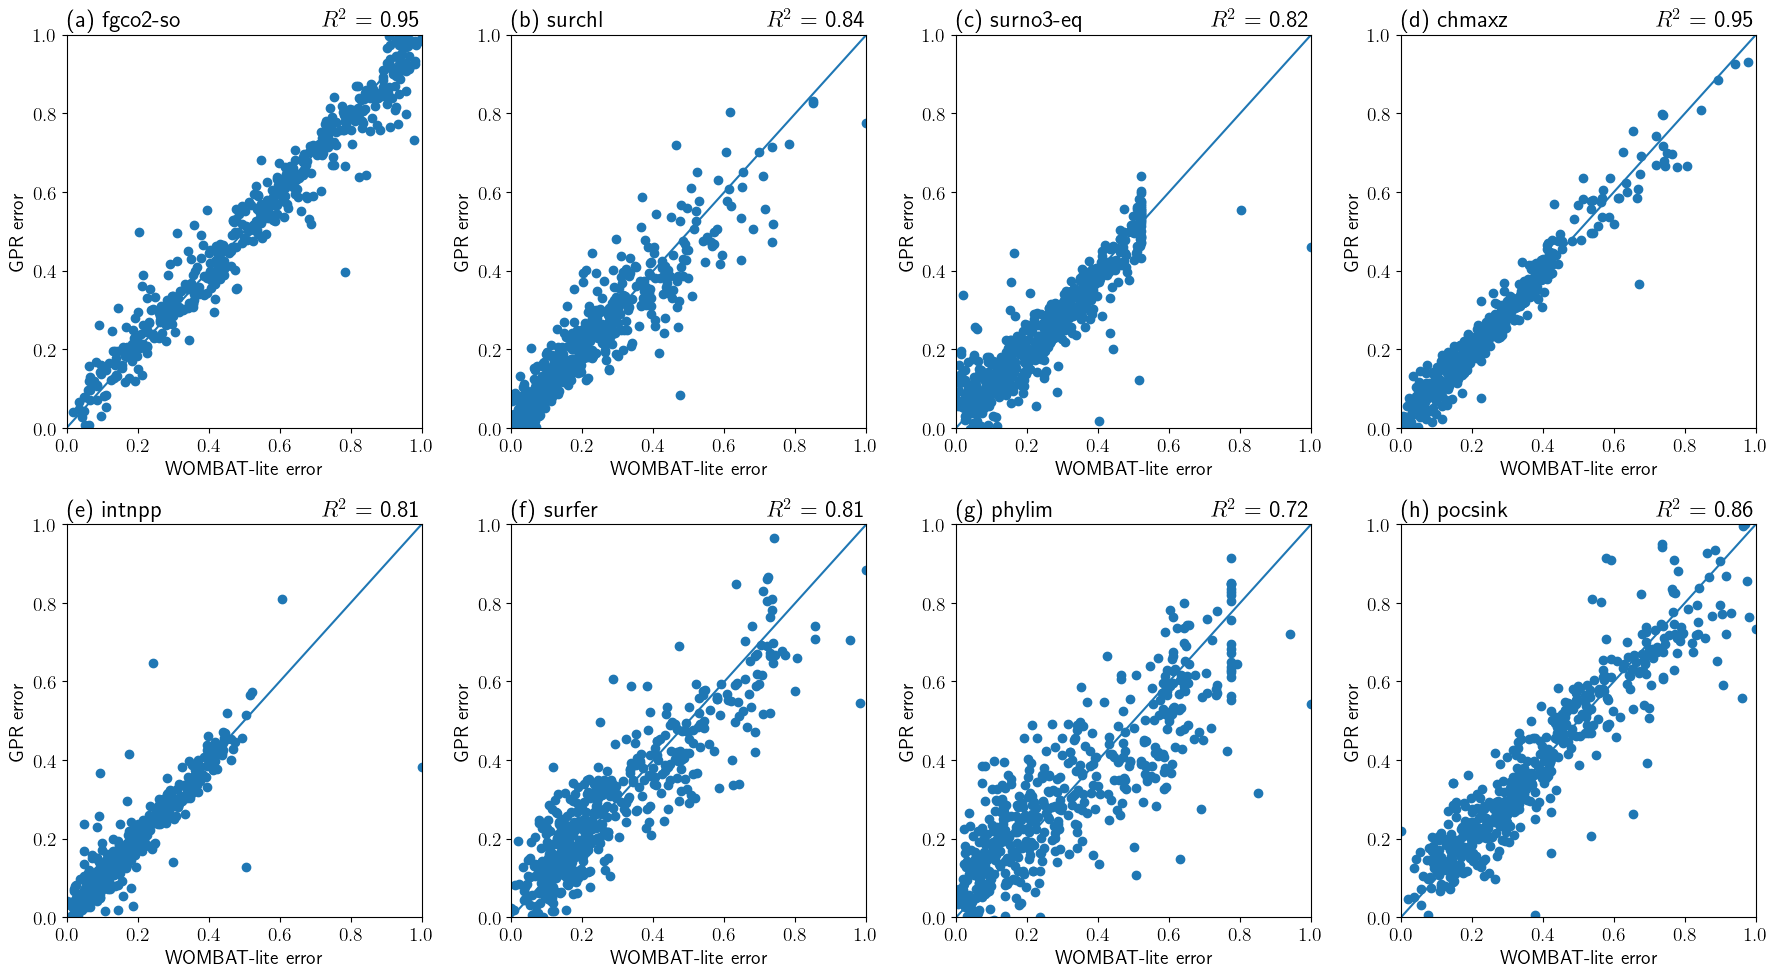

In [59]:
fig = plt.figure(figsize=(18,10))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14)
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']
var_names = ['fgco2-so', 'surchl', 'surno3-eq', 'chmaxz',
             'intnpp', 'surfer', 'phylim', 'pocsink']
for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    ax.plot([0,1])
    ax.scatter(Y_TRUE[:,i],Y_PRED[:,i])
    ax.set_title(abc[i]+var_names[i],
               loc='left')
    ax.set_title('$R^2$ = '+str(round(r2_score(Y_TRUE[:,i],Y_PRED[:,i]),2)),
               loc='right')
    ax.set_xlabel('WOMBAT-lite error')
    ax.set_ylabel('GPR error')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
plt.tight_layout()
plt.savefig('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/Fig_4_Opt_GPR_accuracy_512.png',
            dpi=600,bbox_inches='tight')

In [61]:
%%time
import warnings
warnings.filterwarnings('ignore')
GPR_score = np.zeros((8,3,8))
N = [128,256,512]
for i in range(8):
    kernel = ConstantKernel()+Matern(length_scale=np.ones((13,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    for j in range(3):
        n = int(N[j]/8)
        y_pred = np.zeros(1)
        y_true = np.zeros(1)
        for k in range(8):
            X_train = pd.concat([X_O.iloc[0:k*n,:],X_O.iloc[(k+1)*n:N[j],:]],axis=0)
            X_test = X_O.iloc[k*n:(k+1)*n,:]
            y_train = np.concatenate([Y_O[0:k*n,i],Y_O[(k+1)*n:N[j],i]],axis=0)
            y_test = Y_O[k*n:(k+1)*n,i]
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            GPR_score[i,j,k] = r2_score(y_test,y_hat)
            y_pred = np.append(y_pred,y_hat,axis=0)
            y_true = np.append(y_true,y_test,axis=0)
        y_pred = pd.DataFrame(y_pred[1:])
        y_true = pd.DataFrame(y_true[1:])
        print(variables[i],'N=',N[j],r2_score(y_true,y_pred))

fgco2_so N= 128 0.8930840410183162
fgco2_so N= 256 0.9151133417202757
fgco2_so N= 512 0.9487446204710285
surchl N= 128 0.704978773435143
surchl N= 256 0.8223858764244282
surchl N= 512 0.8386685824678382
surno3-eq-log N= 128 0.49018906632924397
surno3-eq-log N= 256 0.7294002749166111
surno3-eq-log N= 512 0.8212056503635624
chmaxz N= 128 0.8657164352599144
chmaxz N= 256 0.9282396768282657
chmaxz N= 512 0.9541230286437924
intnpp N= 128 0.8046154423723835
intnpp N= 256 0.8109384609587091
intnpp N= 512 0.8094250899457665
surfer N= 128 0.5493399581110006
surfer N= 256 0.6668626920336012
surfer N= 512 0.8059135489328679
phylim N= 128 0.4374957106633397
phylim N= 256 0.6149311149124788
phylim N= 512 0.7227435063935188
pocsink N= 128 0.7674598232631277
pocsink N= 256 0.8074025609116419
pocsink N= 512 0.8618507551598465
CPU times: user 16min 26s, sys: 4min, total: 20min 27s
Wall time: 20min 27s


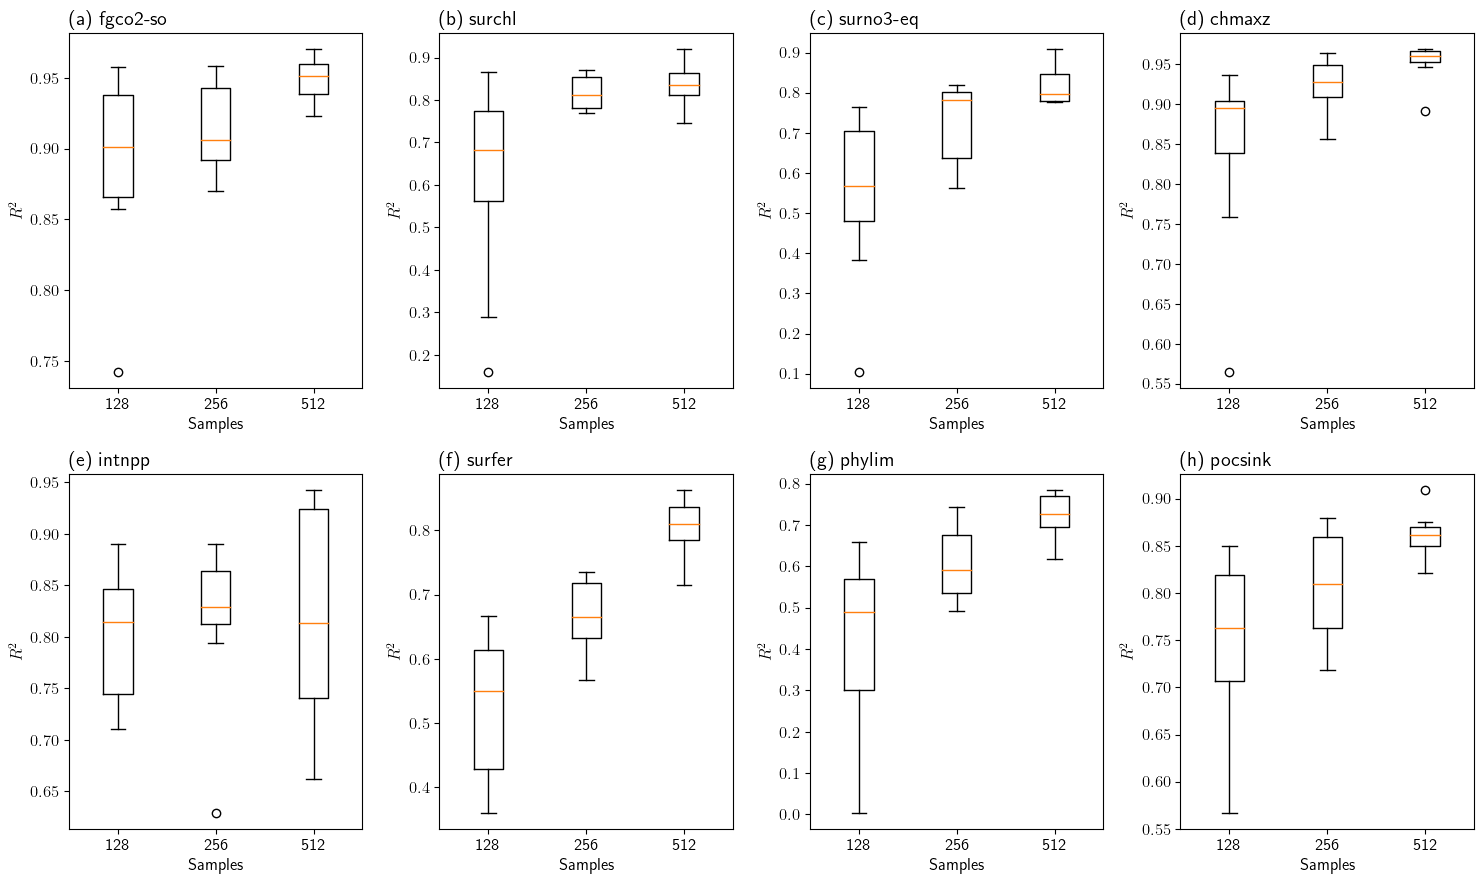

In [62]:
fig = plt.figure(figsize=(15,9))
plt.rc('font', size=12)    # fontsize of the all text
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('xtick', labelsize=12)
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']
for i in range(8):
    axs = fig.add_subplot(2,4,i+1)
    axs.boxplot(GPR_score[i,0:3,:].T)
    axs.set_title(abc[i]+var_names[i],loc='left')
    axs.set_ylabel('$R^2$')
    axs.set_xlabel('Samples')
    axs.set_xticklabels(['128','256','512'])
plt.subplots_adjust(wspace=0.3,hspace=0.4)
plt.tight_layout()
plt.savefig('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/Fig_5_Opt_GPR_sample_sensitivity_512.png',
            dpi=600,bbox_inches='tight')

In [63]:
%%time
data_folder = '/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis'
var_names = ['fgco2-so', 'surchl', 'surno3-eq', 'chmaxz', 
             'intnpp', 'surfer', 'phylim', 'pocsink']
for i in range(len(var_names)):
    y = Y_O[:,i]
    kernel = ConstantKernel()+Matern(length_scale=np.ones((13,1)), nu=1.5)+WhiteKernel(noise_level=1e-10)
    model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    model.fit(X_O, y)
    filename = f'{data_folder}/GPR_{var_names[i]}.joblib'
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

Model saved to /g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/GPR_fgco2-so.joblib
Model saved to /g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/GPR_surchl.joblib
Model saved to /g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/GPR_surno3-eq.joblib
Model saved to /g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/GPR_chmaxz.joblib
Model saved to /g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/GPR_intnpp.joblib
Model saved to /g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/GPR_surfer.joblib
Model saved to /g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/GPR_phylim.joblib
Model saved to /g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/GPR_pocsink.joblib
CPU times: user 2min 38s, sys: 40.1 s, total: 3min 18s
Wall time: 3min 18s


In [64]:
var_names = ['fgco2-so', 'surchl', 'surno3-eq', 'chmaxz',
             'intnpp', 'surfer', 'phylim', 'pocsink']
model_folder = '/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis'
for i, var_name in enumerate(var_names):
    
    # Load the saved model 
    model = joblib.load(f'{model_folder}/GPR_{var_name}.joblib')
    
    # Predict using the fitted model
    predictions = model.predict(X_O)
    
    # Print the minimum and maximum predicted values
    min_pred = np.min(predictions)
    max_pred = np.max(predictions)
    print(f"Variable: {var_name}; Min Prediction: {min_pred}; Max Prediction: {max_pred}")

Variable: fgco2-so; Min Prediction: -3.092333621168564e-05; Max Prediction: 1.0000840763942733
Variable: surchl; Min Prediction: -0.0002616724256654379; Max Prediction: 0.9954052025430826
Variable: surno3-eq; Min Prediction: 0.0002235846074221115; Max Prediction: 0.9996032725847428
Variable: chmaxz; Min Prediction: 0.0011023185318492779; Max Prediction: 1.0049679297582088
Variable: intnpp; Min Prediction: 0.00011468997234942435; Max Prediction: 0.997149567559589
Variable: surfer; Min Prediction: 0.001796493108344066; Max Prediction: 0.9910130621735789
Variable: phylim; Min Prediction: -0.029535353631317207; Max Prediction: 0.844370125843291
Variable: pocsink; Min Prediction: 0.0002684168952953314; Max Prediction: 0.9995026776222176


In [5]:
#----------------------------------Bayesian Optimisation----------------------------------
# Define prior function
def lnprior(theta):
    if np.all(theta >= 0) and np.all(theta <= 1):
        return 0.0  # log(1) for uniform prior
    return -np.inf  # log(0)

# Define the parameter filling function
def param_fill(sens_params, theta, opt_params, opt_values):
    # Define all parameters and sensitive parameters
    all_params = ['P1', 'P2', 'P3','P4', 'P5', 'P6','P7', 'P8', 'P9','P10', 'P11', 'P12',
             'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25']
    # Find the indices of the sensitive parameters in the all_params list
    sens_indices = [all_params.index(param) for param in sens_params]
    # Find the indices of the optimised parameters in the all_params list
    opt_indices = [all_params.index(param) for param in opt_params]
    # Create a sample with all parameters set to 0.5
    sample = np.full(len(all_params), 0.5)
    # Randomly vary only the sensitive parameters
    sample[sens_indices] = theta
    # Assign and fix optimum parameter values
    if opt_values is not None:
        sample[opt_indices] = opt_values
    return sample

# Define the log-posterior function - Bayes Theorem
def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

# Define the optimization function
def optmise(ndim, nsteps):
    
    # Set up the sampler
    ndim, nwalkers = ndim, 50
    pos = [np.random.rand(ndim) for i in range(nwalkers)]
    nsteps = nsteps
    burnin = 1000
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
        # Run MCMC for some steps
        sampler.run_mcmc(pos, nsteps, progress=True)
    
    samples = sampler.get_chain()
    tau = sampler.get_autocorr_time()
    print('Autocorrelation time:', tau)
    all_chains = sampler.chain
    #samples = all_chains[:, burnin:, :].reshape((-1, ndim))
    return all_chains

# Define the parameter mode calculation function
def pmp(data):
    kde = gaussian_kde(data)
    
    # Create a grid of points over the data range
    x_grid = np.linspace(data.min(), data.max(), 1000)
    
    # Evaluate the KDE on the grid points
    kde_values = kde(x_grid)
    
    # Find the maximum KDE value (mode)
    max_kde_value = kde_values.max()
    mode_value = x_grid[np.argmax(kde_values)]
    return mode_value

In [6]:
#sens_params = ['P1', 'P4', 'P6', 'P7', 'P10', 'P11', 'P14', 'P17', 'P19', 'P20', 'P21']
# Load all gpr models
model_folder = '/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis'
fgco2 = joblib.load(f'{model_folder}/GPR_fgco2-so.joblib')
surchl = joblib.load(f'{model_folder}/GPR_surchl.joblib')
surno3 = joblib.load(f'{model_folder}/GPR_surno3-eq.joblib')
chmaxz = joblib.load(f'{model_folder}/GPR_chmaxz.joblib')
intnpp = joblib.load(f'{model_folder}/GPR_intnpp.joblib')
surfer = joblib.load(f'{model_folder}/GPR_surfer.joblib')
phylim = joblib.load(f'{model_folder}/GPR_phylim.joblib')
pocsink = joblib.load(f'{model_folder}/GPR_pocsink.joblib')

def lnlike(theta):
    predicted_nrmse = (np.maximum(fgco2.predict([theta])[0], 0) + np.maximum(surchl.predict([theta])[0], 0) +
                       np.maximum(surno3.predict([theta])[0], 0) + np.maximum(chmaxz.predict([theta])[0], 0) +
                       np.maximum(intnpp.predict([theta])[0], 0) + np.maximum(surfer.predict([theta])[0], 0) + 
                      np.maximum(phylim.predict([theta])[0], 0) + np.maximum(pocsink.predict([theta])[0], 0))
    desired_nrmse = 0.0
    desired_std = 0.05
    # Gaussian likelihood centered at desired_nrmse with desired_std
    return -0.5 * ((predicted_nrmse - desired_nrmse) / desired_std)**2

opt_chains = optmise(13, 100000)
burnin = 10000
opt_samples = opt_chains[:, burnin:, :].reshape((-1, 13))

opt_values = [pmp(opt_samples[:, i]) for i in range(13)]
print('Optimised sample set: ', opt_values)

# Print NRMSE predictions for each model
var_names = ['fgco2-so', 'surchl', 'surno3-eq', 'chmaxz', 
             'intnpp', 'surfer', 'phylim', 'pocsink']
for var_name in var_names:
    gpr_model = joblib.load(f'{model_folder}/GPR_{var_name}.joblib')
    cost = gpr_model.predict([opt_values])
    print(f'Variable: {var_name}; Cost: {cost}')

# Run lnlike with the optimized values
log_likelihood = lnlike(opt_values)
print(f'Log Likelihood: {log_likelihood}')          

100%|██████████| 100000/100000 [25:33<00:00, 65.19it/s]


Autocorrelation time: [595.80914062 615.33772045 640.61508452 644.38861211 569.28953394
 674.50753513 656.74162065 613.99986535 654.42208647 693.99561094
 718.82543832 673.34680108 657.39523974]
Optimised sample set:  [0.7761653085817841, 0.7561331598531613, 0.5006563142125222, 0.8944089838434924, 0.38833832680187114, 0.017105214202776504, 0.0019330946161059378, 0.0020183104193942526, 0.8723662368556889, 0.023023925547611585, 0.9540592730706673, 0.8612974854796249, 0.22244250995711248]
Variable: fgco2-so; Cost: [0.00200833]
Variable: surchl; Cost: [-0.01313768]
Variable: surno3-eq; Cost: [-0.01663912]
Variable: chmaxz; Cost: [0.0366082]
Variable: intnpp; Cost: [0.03258723]
Variable: surfer; Cost: [0.02669109]
Variable: phylim; Cost: [0.02377838]
Variable: pocsink; Cost: [-0.03809753]
Log Likelihood: -2.960874792018235


$\alpha_{a}$ -  p2.5:  0.644042518070113 p97.5:  0.9064088054555801
B$^{thresh}_{p}$ -  p2.5:  0.4751638726953781 p97.5:  0.942909549601181
K$^{N}_{p}$ -  p2.5:  0.34546887939355236 p97.5:  0.7662786355352691
K$^{dFe}_{p}$ -  p2.5:  0.6880379080565462 p97.5:  0.9906067277307833
$Q^{\prime\prime} \frac{Fe}{C}_{p}$ -  p2.5:  0.23267296987919261 p97.5:  0.5566434004060843
$Q^{*} \frac{Chl}{C}_{p}$ -  p2.5:  0.006051915675642561 p97.5:  0.4517551010140258
$\gamma^{0}_{p}$ -  p2.5:  0.0005520333213733155 p97.5:  0.07102222447433033
$\epsilon$ -  p2.5:  0.0005981377970537243 p97.5:  0.06940659417682743
$\Gamma^{0}_{z}$ -  p2.5:  0.566164305832773 p97.5:  0.9901239938918436
$\beta_{h}$ -  p2.5:  0.0086994126846731 p97.5:  0.7450091704492336
$\gamma^{0}_{d}$ -  p2.5:  0.5110091671906658 p97.5:  0.9925325844550608
$\omega^{0}_{d}$ -  p2.5:  0.5206700216743063 p97.5:  0.9865753261079429
$\beta_{a}$ -  p2.5:  0.016506256757123694 p97.5:  0.5822041840485388


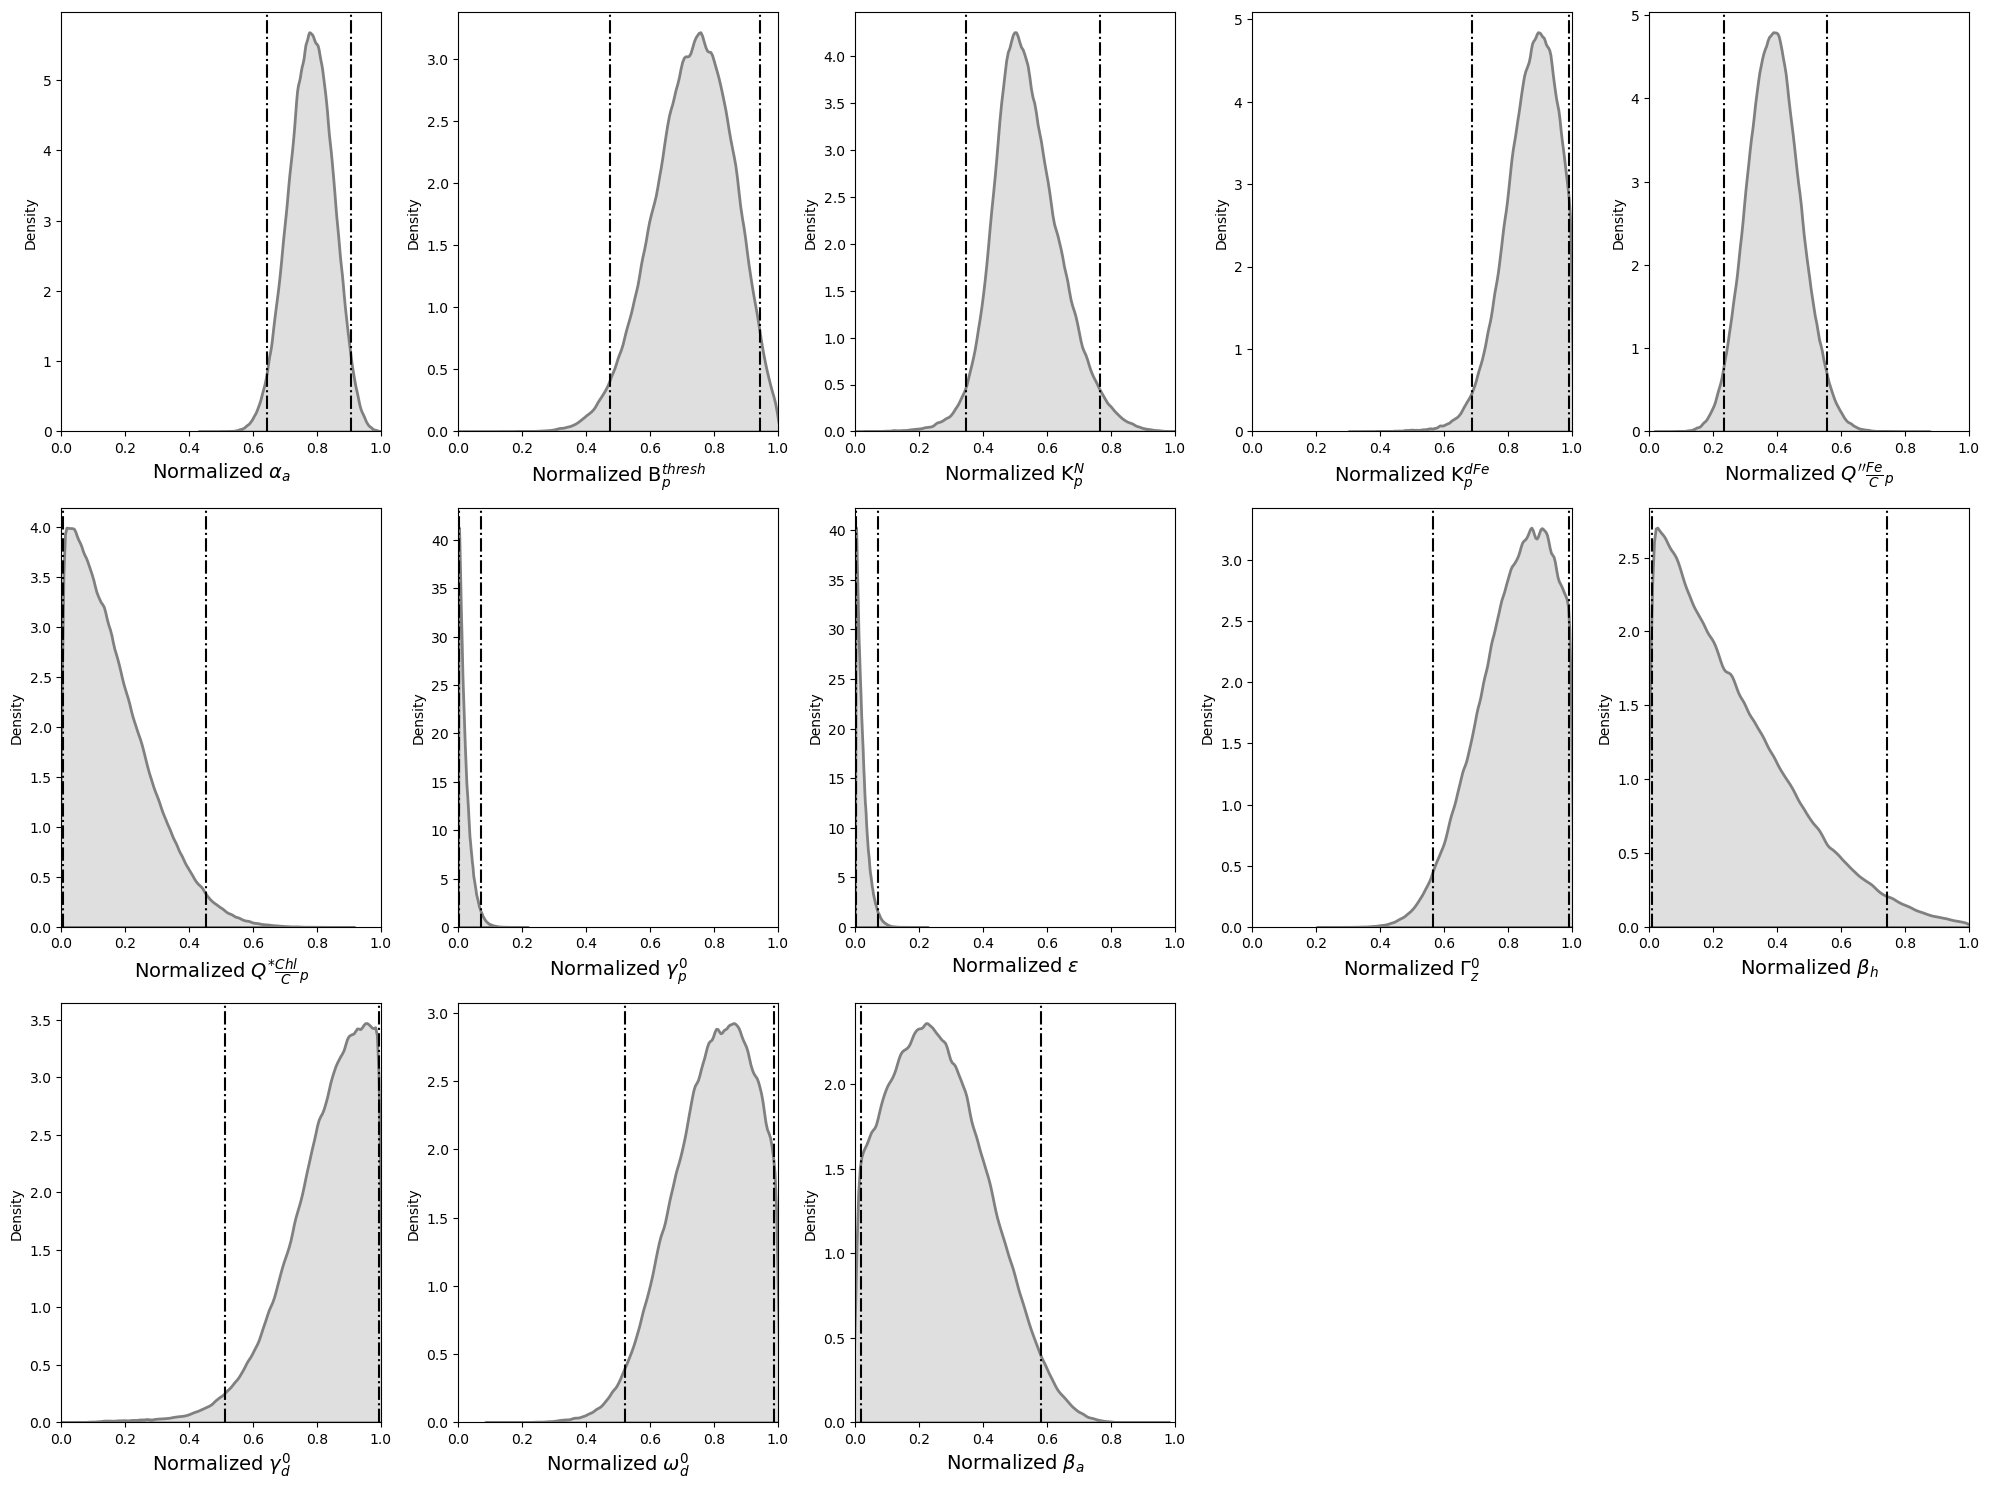

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 15))  # Create a 4x3 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

#opt_params = ['P1', 'P3', 'P4', 'P6', 'P7', 'P10', 'P11', 'P14', 'P17', 'P19', 'P20', 'P21', 'P26']
opt_params = [r'$\alpha_{a}$', r'B$^{thresh}_{p}$', r'K$^{N}_{p}$', r'K$^{dFe}_{p}$', 
              r"$Q^{\prime\prime} \frac{Fe}{C}_{p}$", r'$Q^{*} \frac{Chl}{C}_{p}$', r'$\gamma^{0}_{p}$', 
              r'$\epsilon$', r'$\Gamma^{0}_{z}$', r'$\beta_{h}$', r'$\gamma^{0}_{d}$', r'$\omega^{0}_{d}$', r'$\beta_{a}$']
for i in range(13):
    sns.kdeplot(opt_samples[:, i], fill=True, color='gray', linewidth=2, ax=axes[i])
    
    # Adding 2-sigma confidence interval
    lower, upper = np.percentile(opt_samples[:, i], [2.5, 97.5])
    print(f'{opt_params[i]} - ','p2.5: ', lower, 'p97.5: ', upper)
    axes[i].axvline(x=lower, color='black', linestyle='-.')
    axes[i].axvline(x=upper, color='black', linestyle='-.')
    
    axes[i].set_xlim(0, 1)
    axes[i].set_xlabel(f"Normalized {opt_params[i]}", fontsize=14)

# Hide the empty subplot (last one in a 4x3 grid, total 12 subplots)
axes[-1].axis('off')
axes[-2].axis('off')

plt.tight_layout()
#plt.savefig('/g/data/xv83/jp6794/WRF/Exps/Pearse/August_analysis/Fig_6_Opt_post_dist_non-negative-nrmse_100k_new_cost.png',
#            dpi=600,bbox_inches='tight')

In [20]:
# Draw parameter sets from the posterior distribution
np.random.seed(99)
n_samples = 20  # or however many you can afford to run
# Randomly draw 10 sets of 11 parameter samples
random_samples = opt_samples[np.random.choice(opt_samples.shape[0], n_samples, replace=False)]

In [22]:
all_params = ['P1', 'P2', 'P3','P4', 'P5', 'P6','P7', 'P8', 'P9','P10', 'P11', 'P12',
             'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25']
'''
var_names = ['fgco2-so', 'surchl', 'surno3-eq', 
             'chmaxz', 'intnpp', 'surfer']
'''
var_names = ['fgco2-so', 'surchl', 'surno3-eq', 
             'chmaxz', 'intnpp', 'surfer', 'phylim', 'pocsink']
print('Variables: ', var_names)
# Find the indices of the sensitive parameters in the all_params list
sens_indices = [all_params.index(param) for param in sens_params]
# Create a sample with all parameters set to 0.5
sample = np.full(len(all_params), 0.5)
# Fill the sensitive parameters with the optimised values
for i in range(np.shape(random_samples)[0]):
    #sample[sens_indices] = random_samples[i, :]
    sample = random_samples[i, :]
    # Format the sample values to 2 decimal places
    formatted_sample = [f"{value:.3f}" for value in sample]
    print(f'Optimal sample set - {i}: [{", ".join(formatted_sample)}]')

    nrmse_list = []
    for var_name in var_names:
        gpr_model = joblib.load(f'{model_folder}/GPR_{var_name}.joblib')
        NRMSE = gpr_model.predict([sample])
        nrmse_list.append(NRMSE[0])
        
    # Format the NRMSE values to 2 decimal places
    formatted_nrmse = [f"{value:.3f}" for value in nrmse_list]
    print(f'N-Error of set - {i}: ', formatted_nrmse)

Variables:  ['fgco2-so', 'surchl', 'surno3-eq', 'chmaxz', 'intnpp', 'surfer', 'phylim', 'pocsink']
Optimal sample set - 0: [0.674, 0.722, 0.526, 0.923, 0.313, 0.263, 0.002, 0.005, 0.580, 0.372, 0.941, 0.936, 0.343]
N-Error of set - 0:  ['0.080', '0.001', '-0.029', '0.010', '0.058', '0.017', '0.023', '-0.017']
Optimal sample set - 1: [0.771, 0.942, 0.541, 0.937, 0.541, 0.100, 0.014, 0.009, 0.960, 0.294, 0.871, 0.874, 0.144]
N-Error of set - 1:  ['0.025', '0.012', '-0.026', '0.047', '0.039', '0.016', '0.047', '0.002']
Optimal sample set - 2: [0.801, 0.855, 0.481, 0.848, 0.452, 0.031, 0.030, 0.017, 0.861, 0.573, 0.710, 0.707, 0.063]
N-Error of set - 2:  ['0.009', '0.029', '-0.015', '0.049', '0.043', '0.038', '0.036', '-0.015']
Optimal sample set - 3: [0.774, 0.624, 0.488, 0.879, 0.259, 0.178, 0.016, 0.004, 0.639, 0.454, 0.704, 0.692, 0.349]
N-Error of set - 3:  ['0.018', '0.002', '-0.013', '0.037', '0.054', '0.076', '0.012', '-0.041']
Optimal sample set - 4: [0.659, 0.890, 0.497, 0.860, 0